In [6]:
import sys
from pathlib import Path

# Detect project root automatically relative to notebook location
project_root = Path.cwd().resolve().parents[0]  # assumes notebook in /notebooks/
if (project_root / "src").exists() and str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.tngmw.config import RAW, PLOTS, SIMULATION, SNAPNUM, SUBID

In [7]:
import yt
import trident
from src.tngmw.config import RAW, PLOTS

# Load the dataset
#ds = yt.load(RAW / "subhalo_432106_cutout_full.hdf5")
# ds = yt.load(RAW / "subhalo_509091_cutout_full.hdf5")
ds = yt.load(RAW / "subhalo_535050_cutout_full.hdf5")
print("Fields available after load:", ds.field_list)

# Add ion fields
ions = ["H I", "C IV", "O VI", "Na I", "Ca II", "Na II"]
trident.add_ion_fields(ds, ions=ions)

# Print fields again to verify what got added
print("Fields after ion addition:", ds.field_list)
print("Derived Fields:", ds.derived_field_list)



yt : [INFO     ] 2025-11-18 11:23:43,584 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-11-18 11:23:43,616 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-18 11:23:43,616 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-18 11:23:43,617 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-11-18 11:23:43,617 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-11-18 11:23:43,617 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-11-18 11:23:43,617 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-11-18 11:23:43,618 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-11-18 11:23:43,619 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-11-18 11:23:43,619 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-11-18 11:23:43,619 Parameters: hubble_con

Fields available after load: [('PartType0', 'CenterOfMass'), ('PartType0', 'Coordinates'), ('PartType0', 'Density'), ('PartType0', 'ElectronAbundance'), ('PartType0', 'EnergyDissipation'), ('PartType0', 'GFM_AGNRadiation'), ('PartType0', 'GFM_CoolingRate'), ('PartType0', 'GFM_Metallicity'), ('PartType0', 'GFM_MetalsTagged'), ('PartType0', 'GFM_Metals_00'), ('PartType0', 'GFM_Metals_01'), ('PartType0', 'GFM_Metals_02'), ('PartType0', 'GFM_Metals_03'), ('PartType0', 'GFM_Metals_04'), ('PartType0', 'GFM_Metals_05'), ('PartType0', 'GFM_Metals_06'), ('PartType0', 'GFM_Metals_07'), ('PartType0', 'GFM_Metals_08'), ('PartType0', 'GFM_Metals_09'), ('PartType0', 'GFM_WindDMVelDisp'), ('PartType0', 'GFM_WindHostHaloMass'), ('PartType0', 'InternalEnergy'), ('PartType0', 'Machnumber'), ('PartType0', 'MagneticField'), ('PartType0', 'MagneticFieldDivergence'), ('PartType0', 'Masses'), ('PartType0', 'NeutralHydrogenAbundance'), ('PartType0', 'ParticleIDs'), ('PartType0', 'Potential'), ('PartType0', 'S

In [8]:
import requests
from src.tngmw.config import SIMULATION, SNAPNUM, SUBID, TNG_API_KEY

# SUBID = 509091  # example subhalo ID
SUBID = 535050  # example subhalo ID
url = f"https://www.tng-project.org/api/{SIMULATION}/snapshots/{SNAPNUM}/subhalos/{SUBID}/"
resp = requests.get(url, headers={"api-key": TNG_API_KEY})
resp.raise_for_status()
detail = resp.json()

pos_x = detail["pos_x"]
pos_y = detail["pos_y"]
pos_z = detail["pos_z"]

print("Subhalo position (ckpc/h):", pos_x, pos_y, pos_z)

Subhalo position (ckpc/h): 20882.9 34952.0 15331.7


In [55]:
from zmq import SUB


def make_ion_proj(ds, center, width_kpc=600):
    ions = ["H I", "C IV", "O VI", "Na I", "Ca II", "Na II"]
    trident.add_ion_fields(ds, ions=ions)
    fields = {
        "H I": ("gas", "H_p0_number_density"),
        "C IV": ("gas", "C_p3_number_density"),
        "O VI": ("gas", "O_p5_number_density"),
        "Na I": ("gas", "Na_p0_number_density"),
        "Ca II": ("gas", "Ca_p1_number_density"),
        "Na II": ("gas", "Na_p1_number_density"),
        
        
    }
    start = ds.arr([pos_x - 70, pos_y - 80, pos_z], "code_length")
    end = ds.arr([pos_x + 70, pos_y + 10, pos_z], "code_length")
    ray = ds.ray(start, end)
    
    # pick two more start and end points for rays randomly within 100 kpc of the center
    import numpy as np
    np.random.seed(42)
    start2 = ds.arr(np.random.uniform(-60, 60, size=3), "code_length")
    start2 = start2 + ds.arr([pos_x, pos_y, pos_z], "code_length")
    end2 = ds.arr(np.random.uniform(-60, 60, size=3), "code_length")
    end2 = end2 + ds.arr([pos_x, pos_y, pos_z], "code_length")
    ray2 = ds.ray(start2, end2)
    start3 = ds.arr(np.random.uniform(-60, 60, size=3), "code_length")
    start3 = start3 + ds.arr([pos_x, pos_y, pos_z], "code_length")
    end3 = ds.arr(np.random.uniform(-60, 60, size=3),
                     "code_length")
    end3 = end3 + ds.arr([pos_x, pos_y, pos_z], "code_length")
    ray3 = ds.ray(start3, end3)
        
        
    for name, fld in fields.items():
        if fld in ds.derived_field_list:
            p = yt.ProjectionPlot(ds, "z", fld, center=center, width=(width_kpc, "kpc"))
            p.set_cmap(fld, "viridis")
            # set the zlim for better contrast from 10^9 to 10^15 for Ca II and Na I
            if name in ["Ca II", "Na I", "Na II", 'C IV']:
                p.set_zlim(fld, 1e10, 1e16)
            # increase the font size everywhere and add more annotations about the group
            p.set_font_size(26)
            p.set_cmap(fld, "magma")
            p.annotate_timestamp(corner="upper_left", redshift=ds.current_redshift,
                                 draw_inset_box=True)
            p.annotate_scale(corner="upper_right")
            p.list_annotations()
            # annotate a ray from start to end
            
            p.annotate_ray(ray,arrow = True, plot_args={"color":"white","linewidth":2})
            p.annotate_ray(ray2,arrow = True, plot_args={"color":"cyan","linewidth":2})
            p.annotate_ray(ray3,arrow = True, plot_args={"color":"magenta","linewidth":2})
            # Save the plot
            p.save(PLOTS / f"{SUBID}_{name.replace(' ', '_')}.png")

In [56]:
make_ion_proj(ds, center=[pos_x, pos_y, pos_z], width_kpc=250)

yt : [WARNING  ] 2025-11-18 11:43:04,887 Field ('gas', 'H_p0_ion_fraction') already exists. Not clobbering.
yt : [WARNING  ] 2025-11-18 11:43:04,887 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-11-18 11:43:04,887 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-11-18 11:43:04,888 Field ('gas', 'H_p0_mass') already exists. Not clobbering.
yt : [WARNING  ] 2025-11-18 11:43:04,888 Field ('gas', 'C_p3_ion_fraction') already exists. Not clobbering.
yt : [WARNING  ] 2025-11-18 11:43:04,888 Field ('gas', 'C_p3_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-11-18 11:43:04,888 Field ('gas', 'C_p3_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-11-18 11:43:04,889 Field ('gas', 'C_p3_mass') already exists. Not clobbering.
yt : [WARNING  ] 2025-11-18 11:43:04,889 Field ('gas', 'O_p5_ion_fraction') already exists. Not clobbering.
yt : [WARNING  ] 2025-11-18 11:43:04,889 Field ('g

0 <yt.visualization.plot_modifications.TimestampCallback object at 0x11ba84d40>
1 <yt.visualization.plot_modifications.ScaleCallback object at 0x11b9ba870>


yt : [INFO     ] 2025-11-18 11:43:06,304 xlim = 20798.225011 20967.574989
yt : [INFO     ] 2025-11-18 11:43:06,305 ylim = 34867.325011 35036.674989
yt : [INFO     ] 2025-11-18 11:43:06,306 xlim = 20798.225011 20967.574989
yt : [INFO     ] 2025-11-18 11:43:06,306 ylim = 34867.325011 35036.674989
yt : [INFO     ] 2025-11-18 11:43:06,306 Making a fixed resolution buffer of (('gas', 'C_p3_number_density')) 800 by 800
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_67451/109469063.py:53: DeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1
  p.annotate_ray(ray,arrow = True, plot_args={"color":"white","linewidth":2})
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_67451/109469063.py:54: DeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1
  p.annotate_ray(ray2,arrow = True, plot_args={"color":"cya

0 <yt.visualization.plot_modifications.TimestampCallback object at 0x11c88dd30>
1 <yt.visualization.plot_modifications.ScaleCallback object at 0x11c6f3ce0>


yt : [INFO     ] 2025-11-18 11:43:07,722 xlim = 20798.225011 20967.574989
yt : [INFO     ] 2025-11-18 11:43:07,722 ylim = 34867.325011 35036.674989
yt : [INFO     ] 2025-11-18 11:43:07,724 xlim = 20798.225011 20967.574989
yt : [INFO     ] 2025-11-18 11:43:07,724 ylim = 34867.325011 35036.674989
yt : [INFO     ] 2025-11-18 11:43:07,725 Making a fixed resolution buffer of (('gas', 'O_p5_number_density')) 800 by 800
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_67451/109469063.py:53: DeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1
  p.annotate_ray(ray,arrow = True, plot_args={"color":"white","linewidth":2})
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_67451/109469063.py:54: DeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1
  p.annotate_ray(ray2,arrow = True, plot_args={"color":"cya

0 <yt.visualization.plot_modifications.TimestampCallback object at 0x11ca4cd40>
1 <yt.visualization.plot_modifications.ScaleCallback object at 0x11dd335c0>


yt : [INFO     ] 2025-11-18 11:43:09,297 xlim = 20798.225011 20967.574989
yt : [INFO     ] 2025-11-18 11:43:09,298 ylim = 34867.325011 35036.674989
yt : [INFO     ] 2025-11-18 11:43:09,299 xlim = 20798.225011 20967.574989
yt : [INFO     ] 2025-11-18 11:43:09,299 ylim = 34867.325011 35036.674989
yt : [INFO     ] 2025-11-18 11:43:09,299 Making a fixed resolution buffer of (('gas', 'Na_p0_number_density')) 800 by 800
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_67451/109469063.py:53: DeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1
  p.annotate_ray(ray,arrow = True, plot_args={"color":"white","linewidth":2})
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_67451/109469063.py:54: DeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1
  p.annotate_ray(ray2,arrow = True, plot_args={"color":"cy

0 <yt.visualization.plot_modifications.TimestampCallback object at 0x11dd44d40>
1 <yt.visualization.plot_modifications.ScaleCallback object at 0x11ca320f0>


yt : [INFO     ] 2025-11-18 11:43:10,952 xlim = 20798.225011 20967.574989
yt : [INFO     ] 2025-11-18 11:43:10,953 ylim = 34867.325011 35036.674989
yt : [INFO     ] 2025-11-18 11:43:10,954 xlim = 20798.225011 20967.574989
yt : [INFO     ] 2025-11-18 11:43:10,954 ylim = 34867.325011 35036.674989
yt : [INFO     ] 2025-11-18 11:43:10,955 Making a fixed resolution buffer of (('gas', 'Ca_p1_number_density')) 800 by 800
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_67451/109469063.py:53: DeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1
  p.annotate_ray(ray,arrow = True, plot_args={"color":"white","linewidth":2})
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_67451/109469063.py:54: DeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1
  p.annotate_ray(ray2,arrow = True, plot_args={"color":"cy

0 <yt.visualization.plot_modifications.TimestampCallback object at 0x11cb2cd40>
1 <yt.visualization.plot_modifications.ScaleCallback object at 0x11bac2b10>


yt : [INFO     ] 2025-11-18 11:43:12,554 xlim = 20798.225011 20967.574989
yt : [INFO     ] 2025-11-18 11:43:12,555 ylim = 34867.325011 35036.674989
yt : [INFO     ] 2025-11-18 11:43:12,556 xlim = 20798.225011 20967.574989
yt : [INFO     ] 2025-11-18 11:43:12,556 ylim = 34867.325011 35036.674989
yt : [INFO     ] 2025-11-18 11:43:12,557 Making a fixed resolution buffer of (('gas', 'Na_p1_number_density')) 800 by 800
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_67451/109469063.py:53: DeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1
  p.annotate_ray(ray,arrow = True, plot_args={"color":"white","linewidth":2})
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_67451/109469063.py:54: DeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1
  p.annotate_ray(ray2,arrow = True, plot_args={"color":"cy

0 <yt.visualization.plot_modifications.TimestampCallback object at 0x11b97d280>
1 <yt.visualization.plot_modifications.ScaleCallback object at 0x11c79b410>


In [88]:
import yt
from src.tngmw.config import RAW, PLOTS

ds = yt.load(RAW / "subhalo_432106_cutout_full.hdf5")
center = [pos_x, pos_y, pos_z]          # from API
width  = (50, "kpc")

axis  = "z"
vfield = ("gas", f"velocity_{axis}")    # ('gas','velocity_z')

p = yt.ProjectionPlot(
    ds, axis, vfield,
    center=center, width=width,
    weight_field=("gas","density"), # density-weighted mean LOS velocity
    buff_size=(1024,1024),
)
p.set_unit(vfield, "km/s")
p.set_cmap(vfield, "RdBu")            # diverging for ± velocities
# p.set_zlim(vfield, -60, 150)           # adjust to your system
out = PLOTS / f"los_velocity_{axis}_{int(width[0])}kpc.png"
p.save(out)
print(out)

yt : [INFO     ] 2025-11-09 10:27:26,592 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-11-09 10:27:26,611 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-09 10:27:26,611 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-09 10:27:26,612 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-11-09 10:27:26,612 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-11-09 10:27:26,612 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-11-09 10:27:26,613 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-11-09 10:27:26,613 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-11-09 10:27:26,613 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-11-09 10:27:26,613 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-11-09 10:27:26,613 Parameters: hubble_con

/Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/los_velocity_z_50kpc.png


In [107]:
import numpy as np

def compute_f_value(Aki, wavelength_A, g_upper, g_lower):
    """
    Compute oscillator strength f_ik from Einstein Aki.
    Aki : Einstein coefficient [s⁻¹]
    wavelength_A : transition wavelength in Å
    g_upper : statistical weight of upper level = 2*J_upper + 1
    g_lower : statistical weight of lower level = 2*J_lower + 1
    Returns f_ik (dimensionless)
    """
    return 1.499e-16 * (wavelength_A**2) * (g_upper / g_lower) * Aki


# ------------------------
# Line data from NIST ASD
# ------------------------
lines = [
    # name, Aki [s⁻¹], λ [Å], J_lower, J_upper
    ("Na I D2", 6.16e7, 5891.583264, 0.5, 1.5),
    ("Na I D1", 6.14e7, 5897.566617, 0.5, 0.5),
    ("Ca II K", 1.47e8, 3933.663,   0.5, 1.5),
    ("Ca II H", 1.40e8, 3968.469,   0.5, 0.5),
]

# Compute f-values
for name, Aki, lam, Jl, Ju in lines:
    g_lower, g_upper = 2*Jl + 1, 2*Ju + 1
    f = compute_f_value(Aki, lam, g_upper, g_lower)
    print(f"{name:10s}:  f = {f:.4f}")

Na I D2   :  f = 0.6410
Na I D1   :  f = 0.3201
Ca II K   :  f = 0.6819
Ca II H   :  f = 0.3305


In [68]:
ldb = trident.LineDatabase('lines.txt')

In [ ]:
ldb.add_line('Na', 'I', 5891.583264, 6.16e7,0.6407)
ldb.add_line('Na', 'I', 5897.566617, 6.14e7,0.3199)
ldb.add_line('Ca', 'II', 3933.663,   1.47e8,0.6346)
ldb.add_line('Ca', 'II', 3968.469,   1.40e8,0.3154)
print("Lines in database:", ldb.lines_all)

Lines in database: [Ly a, Ly b, Ly c, Ly d, Ly e, Ly 6, Ly 7, Ly 8, Ly 9, Ly 10, Ly 11, Ly 12, Ly 13, Ly 14, Ly 15, Ly 16, Ly 17, Ly 18, Ly 19, Ly 20, Ly 21, Ly 22, Ly 23, Ly 24, Ly 25, Ly 26, Ly 27, Ly 28, Ly 29, Ly 30, Ly 31, Ly 32, Ly 33, Ly 34, Ly 35, Ly 36, Ly 37, Ly 38, Ly 39, C I 1657, C I 1560, C I 1329, C I 1280, C I 1277, C I 1261, C I 1194, C I 1193, C I 1189, C I 1158, C II* 1336, C II 1335, C II* 1037, C II 1036, C II 904, C III 977, C IV 1551, C IV 1548, N I 1201, N I 1200, N I 1200, N I 1135, N I 1134, N I 1134, N I 965, N I 965, N I 964, N I 954, N I 954, N I 954, N I 953, N I 952, N I 952, N II 1084, N II 916, N III 990, N IV 765, N V 1243, N V 1239, O I* 1306, O I* 1305, O I 1302, O I 1039, O I 989, O I 989, O I 976, O I 951, O I 937, O I 930, O I 925, O I 922, O II 834, O II 833, O II 833, O III* 835, O III* 835, O III 833, O III* 703, O III 702, O IV* 790, O IV 788, O IV* 610, O IV 608, O IV* 555, O IV 554, O IV 553, O V 630, O VI 1038, O VI 1032, Ne V* 572, Ne V* 5

## Spectra Generation

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Na I D + Ca II H&K:
- Three rays at impact parameters 20/50/100 kpc (random PA, reproducible seed)
- Spectra with two zoomed 2×2 figures per ray:
    (1) wavelength space (±3 Å around line center)
    (2) velocity space (±500 km/s around systemic)
- Annotated projection maps (Na I, Ca II) showing sightline pierce points
"""

import numpy as np, yt, trident, matplotlib.pyplot as plt
from pathlib import Path
from src.tngmw.config import RAW, PLOTS

# ------------------------------------------------------------------
# Config
# ------------------------------------------------------------------
SEED = 4  # reproducible randomness
rng  = np.random.default_rng(SEED)

CUTOUT = RAW / "subhalo_432106_cutout_full.hdf5"
OUTDIR = (PLOTS / "spectra"); OUTDIR.mkdir(parents=True, exist_ok=True)

# Central wavelengths (vacuum/air distinction is negligible at this level for plotting)
LINE_INFO = [
    ("Na I 5890", "Na I D2", 5889.95095),
    ("Na I 5896", "Na I D1", 5895.92424),
    ("Ca II 3934", "Ca II K", 3933.66300),
    ("Ca II 3968", "Ca II H", 3968.46900),
]
LINE_NAMES_TRIDENT = [li[0] for li in LINE_INFO]
LAM0 = {li[0]: li[2] for li in LINE_INFO}  # map Trident name -> λ0 [Å]

# plot windows
WAVE_HALF_A = 3.0
VEL_HALF_KMS = 500.0
C_KMS = 299_792.458

# sightline geometry
radii_kpc = [20.0, 50.0, 100.0]
Lz_kpc = 350.0  # half-path length

# ------------------------------------------------------------------
# Load dataset, add fields
# ------------------------------------------------------------------
ds = yt.load(CUTOUT)
trident.add_ion_fields(ds, ions=["Na I", "Ca II"])

# IMPORTANT: pos_x, pos_y, pos_z must already be defined (ckpc/h, i.e. code_length here)
# from your earlier TNG API step. Example:
#   center = ds.arr([pos_x, pos_y, pos_z], "code_length")
center = ds.arr([pos_x, pos_y, pos_z], "code_length")

ckpc_to_cl = ds.quan(1.0, "kpc").to("code_length").value
dz = Lz_kpc * ckpc_to_cl

# Pre-choose one random PA per radius (reproducible)
thetas = {r: rng.uniform(0.0, 2.0*np.pi) for r in radii_kpc}

# ------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------
def make_ray(ds, c, r_kpc, theta):
    dx = r_kpc * np.cos(theta) * ckpc_to_cl
    dy = r_kpc * np.sin(theta) * ckpc_to_cl
    p0 = c + ds.arr([dx, dy, -dz], "code_length")
    p1 = c + ds.arr([dx, dy,  dz], "code_length")
    return p0, p1

def make_zoom_figs(tag, lam, flux):
    """Produce two 2×2 figures: wavelength-zoom and velocity-zoom."""
    # Build per-line slices
    wave_panels = []
    vel_panels  = []
    for trident_name, pretty, lam0 in LINE_INFO:
        # wavelength mask
        m = (lam >= lam0 - WAVE_HALF_A) & (lam <= lam0 + WAVE_HALF_A)
        lw, fw = lam[m], flux[m]

        # velocity transform and mask (centered at lam0)
        v = C_KMS * (lam/lam0 - 1.0)
        mv = (v >= -VEL_HALF_KMS) & (v <= +VEL_HALF_KMS)
        lv, fv = v[mv], flux[mv]

        wave_panels.append((pretty, lam0, lw, fw))
        vel_panels.append((pretty, lam0, lv, fv))

    # --- wavelength zooms (2×2) ---
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
    axes = axes.ravel()
    for ax, (pretty, lam0, lw, fw) in zip(axes, wave_panels):
        ax.plot(lw, fw, lw=0.9)
        ax.axvline(lam0, ls="--", lw=0.8)
        ax.set_xlim(lam0 - WAVE_HALF_A, lam0 + WAVE_HALF_A)
        ax.set_title(pretty)
        ax.set_xlabel("Wavelength [Å]")
        ax.grid(alpha=0.3)
    axes[0].set_ylabel("Normalized Flux")
    axes[2].set_ylabel("Normalized Flux")
    fig.tight_layout()
    fig.savefig(OUTDIR / f"{tag}_zoom_wavelength.png", dpi=160)
    plt.close(fig)

    # --- velocity zooms (2×2) ---
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
    axes = axes.ravel()
    for ax, (pretty, lam0, lv, fv) in zip(axes, vel_panels):
        ax.plot(lv, fv, lw=0.9)
        ax.axvline(0.0, ls="--", lw=0.8)
        ax.set_xlim(-VEL_HALF_KMS, +VEL_HALF_KMS)
        ax.set_title(pretty)
        ax.set_xlabel("Velocity [km s$^{-1}$]")
        ax.grid(alpha=0.3)
    axes[0].set_ylabel("Normalized Flux")
    axes[2].set_ylabel("Normalized Flux")
    fig.tight_layout()
    fig.savefig(OUTDIR / f"{tag}_zoom_velocity.png", dpi=160)
    plt.close(fig)

# ------------------------------------------------------------------
# Spectra per ray + zoom plots
# ------------------------------------------------------------------
for r in radii_kpc:
    theta = thetas[r]
    p0, p1 = make_ray(ds, center, r, theta)

    tag = f"rho{int(r)}kpc_seed{SEED}"
    rayfile = OUTDIR / f"ray_{tag}.h5"

    # Build ray and spectrum
    ray = trident.make_simple_ray(
        ds,
        start_position=p0, end_position=p1,
        data_filename=rayfile,
        lines=LINE_NAMES_TRIDENT,  # use Trident's line labels
        ftype="gas"
    )
    # 1) rewrite redshift fields inside the HDF5 file
    import h5py
    with h5py.File(rayfile, "r+") as f:
        if "grid" not in f:
            raise RuntimeError(f"{rayfile} has no /grid group")
        g = f["grid"]
        if ("redshift" not in g) or ("redshift_eff" not in g):
            raise RuntimeError("Required datasets /grid/redshift and /grid/redshift_eff not found")
        z    = g["redshift"][:]
        z_eff = g["redshift_eff"][:]
        g["redshift_eff"][:] = z_eff - z   # Δz = z_eff - z
        g["redshift"][:]     = 0.0         # set z = 0
    
    # print the column densities of all two ions
    #column_density_HI = ray.r[('gas', 'H_p0_number_density')] * ray.r[('gas', 'dl')]
    # print('HI Column Density = %g' % column_density_HI.sum())
    column_density_NaI = ray.r[('gas', 'Na_p0_number_density')] * ray.r[('gas', 'dl')]
    print(f'Na I Column Density (r={r} kpc) = {column_density_NaI.sum():.3e} cm^-2')
    column_density_CaII = ray.r[('gas', 'Ca_p1_number_density')] * ray.r[('gas', 'dl')]
    print(f'Ca II Column Density (r={r} kpc) = {column_density_CaII.sum():.3e} cm^-2')

    # 2) reload the modified ray as a yt dataset and make the spectrum
    ray = yt.load(str(rayfile))

    sg = trident.SpectrumGenerator(lambda_min=3500.0, lambda_max=6000.0, dlambda=0.01)
    sg.make_spectrum(ray, lines=LINE_NAMES_TRIDENT)

    lam = np.asarray(sg.lambda_field)
    flux = np.asarray(sg.flux_field)

    # Two zoomed figures (wavelength and velocity)
    make_zoom_figs(tag, lam, flux)

# ------------------------------------------------------------------
# Annotated projections (Na I and Ca II fields)
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# Ion-weighted line-of-sight velocity projections (mean v_los)
# ------------------------------------------------------------------
# For axis="z", the LOS component is ("gas","velocity_z").
vel_field = ("gas", "velocity_z")   # default units: cm/s

fields = {
    "Na I": ("gas", "Na_p0_number_density"),
    "Ca II": ("gas", "Ca_p1_number_density"),
    "Gas": ("gas", "density"),
}

for name, ion_ndens in fields.items():
    # Weighted projection: <v_z>_ion = ∫ v_z * n_ion dl / ∫ n_ion dl
    p = yt.ProjectionPlot(
        ds, "z", vel_field,
        center=center, width=(250.0, "kpc"),
        weight_field=ion_ndens
    )
    # Show velocities in km/s with a symmetric diverging palette
    p.set_unit(vel_field, "km/s")
    p.set_cmap(vel_field, "RdBu")
    p.set_zlim(vel_field, -200.0, 200.0)  # adjust if your system has larger |v|

    # Mark the pierce points as before
    for r in radii_kpc:
        theta = thetas[r]
        dx = r * np.cos(theta) * ckpc_to_cl
        dy = r * np.sin(theta) * ckpc_to_cl
        mark3d = [center[0].value + dx, center[1].value + dy, center[2].value]

        p.annotate_marker(
            mark3d,
            coord_system="data",
            marker="x",
            plot_args={"color": "black", "s": 64, "linewidths": 1.4}
        )
        p.annotate_text(
            mark3d, f"{int(r)} kpc",
            coord_system="data",
            text_args={"color": "black", "fontsize": 12, "weight": "bold"}
        )

    p.annotate_title(f"{name} weighted ⟨v_los⟩ (axis=z)")
    p.save(OUTDIR / f"proj_{name.replace(' ','_')}_vlos_weighted_seed{SEED}.png")
    
# ------------------------------------------------------------------
# LOS-velocity projections WITHOUT ion weighting (SPH-compatible)
#   - unweighted: weight_field=None  → mean LOS velocity per pixel
#   - can switch axis="x"/"y"/"z" to visualize different components
# ------------------------------------------------------------------
axis = "z"
vel_field = ("gas", f"velocity_{axis}")  # component along LOS

def vlos_projection(axis="z", width_kpc=250.0, vabs_kms=200.0, cmap="RdBu"):
    vel_field = ("gas", f"velocity_{axis}")
    
    # Use ParticleProjectionPlot for SPH datasets (TNG, SIMBA)
    p = yt.ParticleProjectionPlot(
        ds,
        axis,
        vel_field,
        center=center,
        width=(width_kpc, "kpc"),
        weight_field=None,  # unweighted; use ("gas","density") for mass-weighted
    )

    p.set_unit(vel_field, "km/s")
    p.set_cmap(vel_field, cmap)
    p.set_zlim(vel_field, -vabs_kms, +vabs_kms)

    # annotate pierce points for all rays
    for r in radii_kpc:
        theta = thetas[r]
        dx = r * np.cos(theta) * ckpc_to_cl
        dy = r * np.sin(theta) * ckpc_to_cl
        mark3d = [center[0].value + dx, center[1].value + dy, center[2].value]

        p.annotate_marker(
            mark3d,
            coord_system="data",
            marker="x",
            plot_args={"color": "black", "s": 64, "linewidths": 1.4},
        )
        p.annotate_text(
            mark3d,
            f"{int(r)} kpc",
            coord_system="data",
            text_args={"color": "black", "fontsize": 12, "weight": "bold"},
        )

    p.annotate_title(rf"Unweighted LOS Velocity (v$_{{\rm {axis}}}$)")
    return p


# --- Make and save the unweighted LOS-velocity projection ---
proj = vlos_projection(axis="z", width_kpc=250.0, vabs_kms=400.0)
proj.save(OUTDIR / f"proj_vlos_unweighted_{axis}_seed{SEED}.png")

yt : [INFO     ] 2025-11-09 12:24:43,734 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-11-09 12:24:43,764 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-09 12:24:43,764 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-09 12:24:43,765 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-11-09 12:24:43,765 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-11-09 12:24:43,765 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-11-09 12:24:43,766 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-11-09 12:24:43,767 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-11-09 12:24:43,767 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-11-09 12:24:43,767 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-11-09 12:24:43,768 Parameters: hubble_con

Na I Column Density (r=20.0 kpc) = 2.023e+09 cm**(-2) cm^-2
Ca II Column Density (r=20.0 kpc) = 1.927e+13 cm**(-2) cm^-2


Adding line - Ca II 3968 [3968.469000 A]: 100%|██████████| 671/671 [00:00<00:00, 74964.12it/s]
yt : [INFO     ] 2025-11-09 12:24:45,400 Getting segment at z = 2.220446049250313e-16: [0.22454416 0.24528633 0.05655457] unitary to [0.22454416 0.24528633 0.07010257] unitary.
yt : [INFO     ] 2025-11-09 12:24:45,400 Getting subsegment: [0.22454416 0.24528633 0.05655457] unitary to [0.22454416 0.24528633 0.07010257] unitary.
yt : [INFO     ] 2025-11-09 12:24:45,943 Saving field data to yt dataset: /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/ray_rho50kpc_seed4.h5.
yt : [INFO     ] 2025-11-09 12:24:45,954 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-09 12:24:45,955 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-09 12:24:45,955 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-11-09 12:24:45,955 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length


Na I Column Density (r=50.0 kpc) = 2.320e+03 cm**(-2) cm^-2
Ca II Column Density (r=50.0 kpc) = 2.060e+07 cm**(-2) cm^-2


Adding line - Ca II 3968 [3968.469000 A]: 100%|██████████| 578/578 [00:00<00:00, 122408.87it/s]
yt : [INFO     ] 2025-11-09 12:24:46,331 Getting segment at z = 2.220446049250313e-16: [0.22742334 0.24506732 0.05655457] unitary to [0.22742334 0.24506732 0.07010257] unitary.
yt : [INFO     ] 2025-11-09 12:24:46,332 Getting subsegment: [0.22742334 0.24506732 0.05655457] unitary to [0.22742334 0.24506732 0.07010257] unitary.
yt : [INFO     ] 2025-11-09 12:24:46,908 Saving field data to yt dataset: /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/ray_rho100kpc_seed4.h5.
yt : [INFO     ] 2025-11-09 12:24:46,920 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-09 12:24:46,921 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-09 12:24:46,921 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-11-09 12:24:46,921 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_lengt

Na I Column Density (r=100.0 kpc) = 1.576e+03 cm**(-2) cm^-2
Ca II Column Density (r=100.0 kpc) = 6.279e+07 cm**(-2) cm^-2


Adding line - Ca II 3968 [3968.469000 A]: 100%|██████████| 451/451 [00:00<00:00, 129183.30it/s]
yt : [INFO     ] 2025-11-09 12:24:47,539 xlim = 7808.155011 7977.504989
yt : [INFO     ] 2025-11-09 12:24:47,539 ylim = 8502.755011 8672.104989
yt : [INFO     ] 2025-11-09 12:24:47,540 xlim = 7808.155011 7977.504989
yt : [INFO     ] 2025-11-09 12:24:47,541 ylim = 8502.755011 8672.104989
yt : [INFO     ] 2025-11-09 12:24:47,542 Making a fixed resolution buffer of (('gas', 'velocity_z')) 800 by 800
yt : [INFO     ] 2025-11-09 12:24:49,429 Making a fixed resolution buffer of (('gas', 'Na_p0_number_density')) 800 by 800
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_74061/3740536669.py:206: DeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1
  p.annotate_marker(
yt : [INFO     ] 2025-11-09 12:24:51,281 Saving plot /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/proj_Na_I_vlos_we

['/Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/proj_vlos_unweighted_z_seed4.png']

=== HDF5 TREE ===
[G] /grid
[D] /grid/Ca_p1_number_density  shape=(927,) dtype=float64
[D] /grid/H_nuclei_density  shape=(927,) dtype=float64
[D] /grid/Na_p0_number_density  shape=(927,) dtype=float64
[D] /grid/dl  shape=(927,) dtype=float64
[D] /grid/l  shape=(927,) dtype=float64
[D] /grid/redshift  shape=(927,) dtype=float64
[D] /grid/redshift_dopp  shape=(927,) dtype=float64
[D] /grid/redshift_eff  shape=(927,) dtype=float64
[D] /grid/relative_velocity_x  shape=(927,) dtype=float64
[D] /grid/relative_velocity_y  shape=(927,) dtype=float64
[D] /grid/relative_velocity_z  shape=(927,) dtype=float64
[D] /grid/temperature  shape=(927,) dtype=float64
[D] /grid/velocity_los  shape=(927,) dtype=float64
[D] /grid/x  shape=(927,) dtype=float64
[D] /grid/y  shape=(927,) dtype=float64
[D] /grid/z  shape=(927,) dtype=float64

Layout: grid ; n_cells=927 ; series=16
 - /grid/redshift  (unit='', N=927)
 - /grid/redshift_dopp  (unit='', N=927)
 - /grid/redshift_eff  (unit='', N=927)
 - /grid/Ca_p1_n

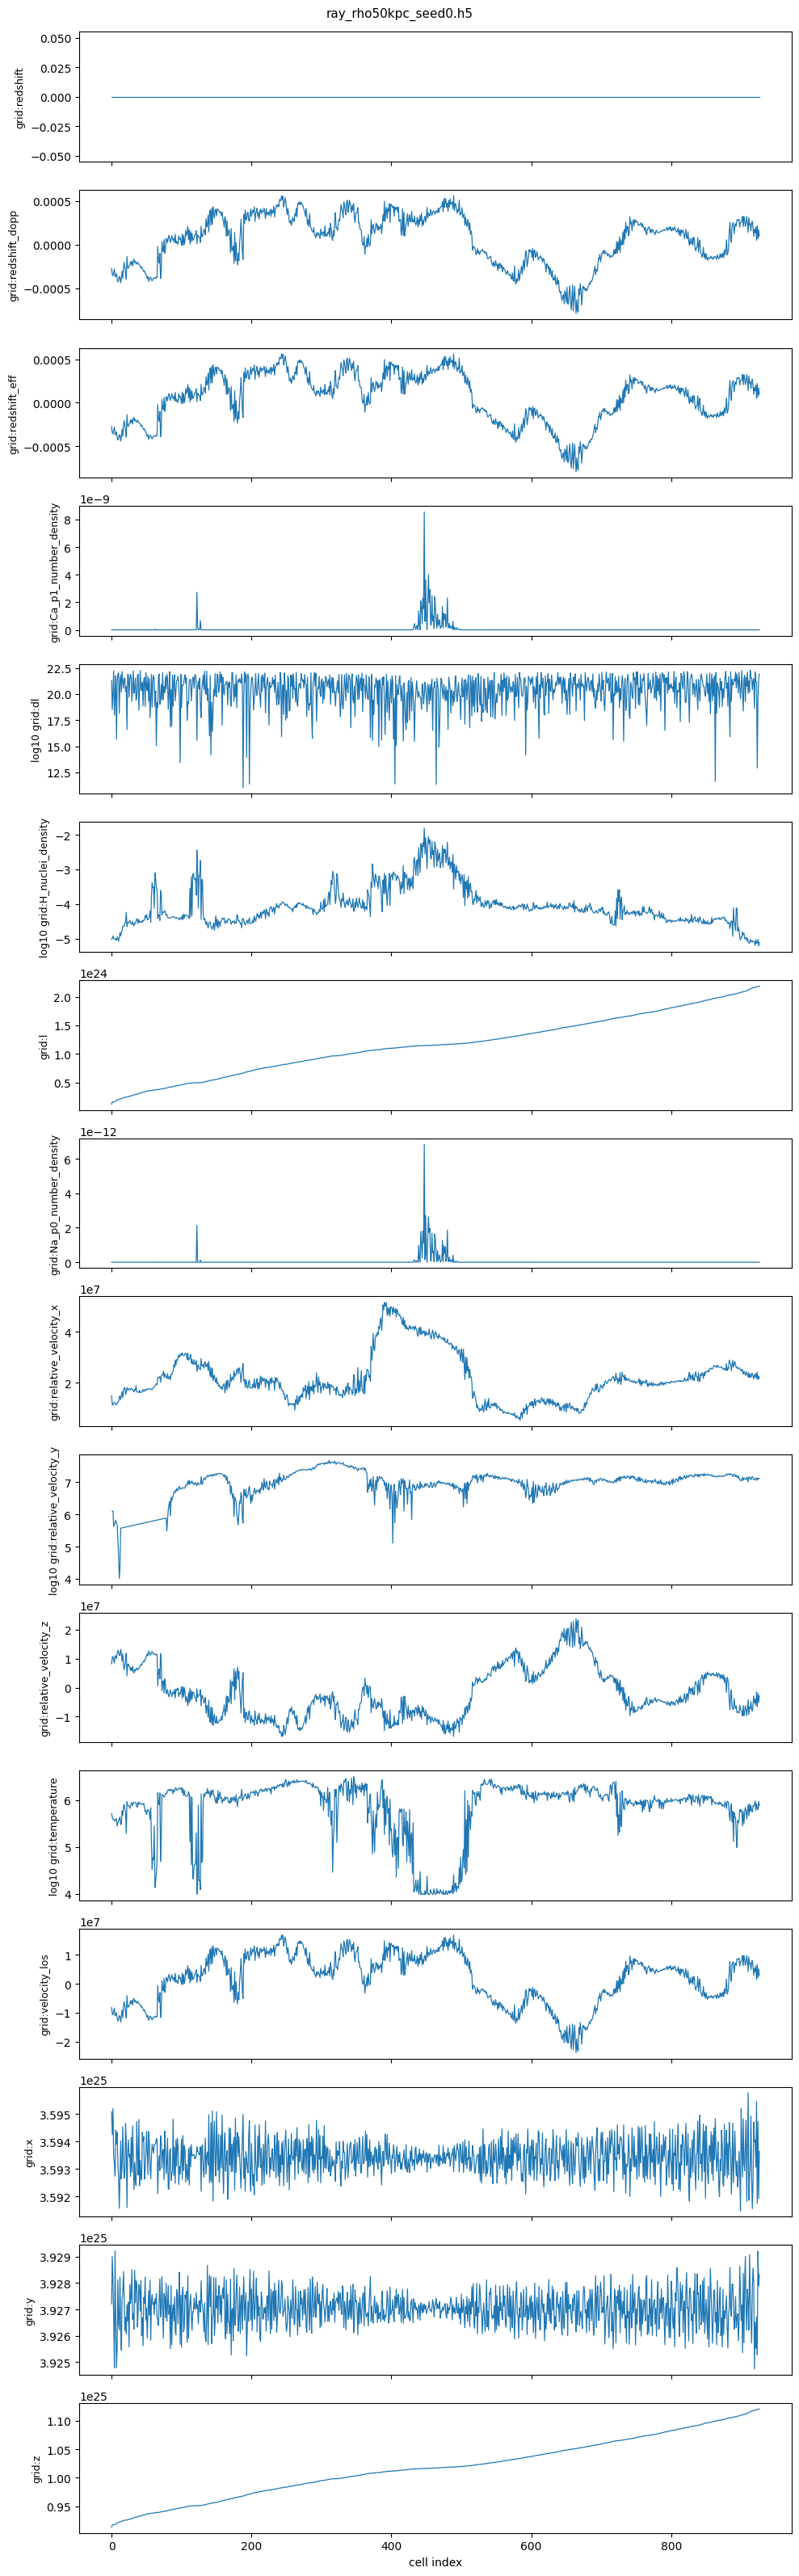

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Compact inspector for Trident ray files (handles /ray or /grid layouts).
- Prints HDF5 tree (one pass).
- Collects every 1-D per-cell array under /ray/** or /grid/**.
- Plots all series vs. cell index (paged), including redshift, redshift_dopp, redshift_eff.
- Optional spectra zoom panel if /spectrum exists.

Set BUNDLE and INCLUDE_FTYPES as needed.
"""

import os, h5py, numpy as np, matplotlib.pyplot as plt

# ------------------------ CONFIG ------------------------
BUNDLE = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/ray_rho50kpc_seed0.h5"
INCLUDE_FTYPES = ["gas"]      # only applies to the /ray/fields tree; ignored for /grid
PAGE_SIZE = 24
SAVE_DIR = None               # e.g. "/tmp"; None => show()
PLOT_SPECTRA = False
Z_SYS = 0.0
LINE_CENTERS_A = {
    "Na I D2": 5889.95095,
    "Na I D1": 5895.92424,
    "Ca II K": 3933.663,
    "Ca II H": 3968.469,
}
LAM_HW_A = 3.0
VEL_HW_KMS = 500.0
# --------------------------------------------------------

def print_h5_tree(path):
    with h5py.File(path, "r") as f:
        def visit(name, obj):
            k = "G" if isinstance(obj, h5py.Group) else "D"
            line = f"[{k}] /{name}"
            if isinstance(obj, h5py.Dataset):
                line += f"  shape={obj.shape} dtype={obj.dtype}"
            print(line)
        f.visititems(visit)

def _is_numeric(ds: h5py.Dataset) -> bool:
    try:
        return np.issubdtype(ds.dtype, np.number)
    except Exception:
        return False

def _dataset_unit(ds: h5py.Dataset) -> str:
    u = ds.attrs.get("unit", "")
    return u.decode() if isinstance(u, (bytes, bytearray)) else str(u)

def _find_ncells_group(g: h5py.Group) -> int:
    # Prefer explicit pathlength hints if present
    for key in ("dl_cm", "dl", "l"):
        if key in g and isinstance(g[key], h5py.Dataset) and g[key].ndim == 1:
            return int(g[key].shape[0])
    # Fallback: first 1-D numeric dataset in this group (or subgroups)
    for name, obj in g.items():
        if isinstance(obj, h5py.Dataset) and obj.ndim == 1 and _is_numeric(obj):
            return int(obj.shape[0])
    # probe one level down
    for name, obj in g.items():
        if isinstance(obj, h5py.Group):
            for subname, ds in obj.items():
                if isinstance(ds, h5py.Dataset) and ds.ndim == 1 and _is_numeric(ds):
                    return int(ds.shape[0])
    raise RuntimeError("Could not infer n_cells for group")

def _detect_layout(f: h5py.File):
    """
    Returns ('ray', group) if /ray exists, else ('grid', group) if /grid exists.
    Raises if neither exists.
    """
    if "ray" in f:
        return "ray", f["ray"]
    if "grid" in f:
        return "grid", f["grid"]
    raise RuntimeError("Unsupported file: neither '/ray' nor '/grid' present.")

def collect_series(bundle_path, include_ftypes=None, include_convenience=True):
    """
    Returns (series_list, n_cells, layout), where series_list contains dicts:
      {'label','data','unit','path'}
    Works for both /ray and /grid files.
    """
    out = []
    with h5py.File(bundle_path, "r") as f:
        layout, gtop = _detect_layout(f)
        n = _find_ncells_group(gtop)

        if layout == "ray":
            # (A) datasets directly under /ray (convenience)
            if include_convenience:
                for k, obj in gtop.items():
                    if isinstance(obj, h5py.Dataset) and obj.ndim == 1 and _is_numeric(obj) and obj.shape[0] == n:
                        out.append({
                            "label": k,
                            "data": np.array(obj, float),
                            "unit": _dataset_unit(obj),
                            "path": f"/ray/{k}"
                        })
            # (B) fields under /ray/fields/<ftype>/<name>
            if "fields" in gtop:
                g_fields = gtop["fields"]
                for ftype in g_fields.keys():
                    if include_ftypes and ftype not in include_ftypes:
                        continue
                    for name, ds in g_fields[ftype].items():
                        if isinstance(ds, h5py.Dataset) and ds.ndim == 1 and _is_numeric(ds) and ds.shape[0] == n:
                            out.append({
                                "label": f"{ftype}:{name}",
                                "data": np.array(ds, float),
                                "unit": _dataset_unit(ds),
                                "path": f"/ray/fields/{ftype}/{name}"
                            })

        elif layout == "grid":
            # Everything is directly under /grid as 1-D arrays
            for name, ds in gtop.items():
                if isinstance(ds, h5py.Dataset) and ds.ndim == 1 and _is_numeric(ds) and ds.shape[0] == n:
                    out.append({
                        "label": f"grid:{name}",
                        "data": np.array(ds, float),
                        "unit": _dataset_unit(ds),
                        "path": f"/grid/{name}"
                    })

    # sort: redshift triplet first if present (works for both layouts)
    priority = {
        "gas:redshift": 0, "gas:redshift_dopp": 1, "gas:redshift_eff": 2,
        "grid:redshift": 0, "grid:redshift_dopp": 1, "grid:redshift_eff": 2,
    }
    out.sort(key=lambda d: (priority.get(d["label"], 99), d["label"].lower()))
    return out, n, layout

def _logify(label, unit, y):
    y = np.asarray(y, float)
    if label.endswith(":redshift") or label.endswith(":redshift_dopp") or label.endswith(":redshift_eff"):
        return y, False
    m = (y > 0) & np.isfinite(y)
    if m.sum() < 0.8 * y.size:
        return y, False
    dyn = (np.nanmax(y[m]) / max(np.nanmin(y[m]), 1e-300)) if m.any() else 1.0
    keys = ("density", "rho", "cm", "dl", "tau", "nhi", "siii", "cii")
    if dyn > 50 or any(k in label.lower() for k in keys) or any(k in str(unit).lower() for k in keys):
        z = np.full_like(y, np.nan, float); z[m] = np.log10(y[m]); return z, True
    return y, False

def plot_all_series(series, bundle_name="", page_size=24, save_dir=None):
    if not series:
        print("[WARN] no per-cell arrays found"); return
    for i0 in range(0, len(series), page_size):
        chunk = series[i0:i0+page_size]
        n = len(chunk)
        fig_h = max(2.0*n, 6.0)
        fig, axes = plt.subplots(n, 1, figsize=(10, fig_h), sharex=True)
        if n == 1: axes = [axes]
        for ax, ent in zip(axes, chunk):
            y = ent["data"]
            yplot, islog = _logify(ent["label"], ent["unit"], y)
            m = np.isfinite(yplot)
            ax.plot(np.arange(y.size)[m], yplot[m], lw=0.9)
            yl = ent["label"] + (f" [{ent['unit']}]" if ent["unit"] else "")
            if islog: yl = "log10 " + yl
            ax.set_ylabel(yl, fontsize=9)
        axes[-1].set_xlabel("cell index")
        fig.suptitle(bundle_name, fontsize=11, y=0.995)
        fig.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            out = os.path.join(save_dir, f"ray_series_{i0:04d}-{i0+n-1:04d}.png")
            fig.savefig(out, dpi=160); plt.close(fig); print("[saved]", out)
        else:
            plt.show()

def plot_spectra_zoom(bundle_path, line_centers_A, z_sys=0.0, lam_hw=3.0, vel_hw=500.0, save_dir=None):
    if not h5py.is_hdf5(bundle_path):
        print("[WARN] not an HDF5 file; skip spectra"); return
    with h5py.File(bundle_path, "r") as f:
        if "spectrum" not in f:
            print("[INFO] no /spectrum group in this file; skip spectra"); return
        if "raw" not in f["spectrum"] or "lsf" not in f["spectrum"]:
            print("[INFO] /spectrum present but missing raw/lsf; skip spectra"); return
        lam_raw = np.asarray(f["spectrum/raw/lambda_A"][:], float)
        flx_raw = np.asarray(f["spectrum/raw/flux"][:], float)
        lam     = np.asarray(f["spectrum/lsf/lambda_A"][:], float)
        flx     = np.asarray(f["spectrum/lsf/flux"][:], float)

    C = 299792.458
    cols = len(line_centers_A)
    fig, axes = plt.subplots(2, cols, figsize=(4.8*cols, 7.2), sharey='row')
    if cols == 1: axes = np.array([[axes[0]], [axes[1]]])
    for j, (name, lam0) in enumerate(line_centers_A.items()):
        lam_c = lam0*(1+z_sys)
        m_r = (lam_raw > lam_c - lam_hw) & (lam_raw < lam_c + lam_hw)
        m_l = (lam     > lam_c - lam_hw) & (lam     < lam_c + lam_hw)
        axw = axes[0, j]
        if m_r.any(): axw.plot(lam_raw[m_r], flx_raw[m_r], lw=1.2, label="raw")
        if m_l.any(): axw.plot(lam[m_l],     flx[m_l],     lw=1.6, label="LSF")
        axw.axvline(lam_c, ls="--", lw=0.8, c="k")
        axw.set_xlim(lam_c - lam_hw, lam_c + lam_hw)
        if j == 0: axw.set_ylabel("Norm. flux")
        axw.set_title(f"{name}  (λ₀={lam0:.3f} Å)")
        axv = axes[1, j]
        v_r = C*((lam_raw[m_r]/(1+z_sys))/lam0 - 1.0) if m_r.any() else np.array([])
        v_l = C*((lam[m_l]/(1+z_sys))/lam0 - 1.0)     if m_l.any() else np.array([])
        if v_r.size: axv.plot(v_r, flx_raw[m_r], lw=1.2, label="raw")
        if v_l.size: axv.plot(v_l, flx[m_l],     lw=1.6, label="LSF")
        axv.axvline(0.0, ls="--", lw=0.8, c="k")
        axv.set_xlim(-VEL_HW_KMS, VEL_HW_KMS)
        axv.set_xlabel("v [km s$^{-1}$]")
        if j == 0: axv.set_ylabel("Norm. flux")
        if j == 0:
            axw.legend(frameon=False); axv.legend(frameon=False)
    fig.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out = os.path.join(save_dir, "spectra_zoom.png")
        fig.savefig(out, dpi=160); plt.close(fig); print("[saved]", out)
    else:
        plt.show()

if __name__ == "__main__":
    print("=== HDF5 TREE ===")
    print_h5_tree(BUNDLE)

    series, n_cells, layout = collect_series(BUNDLE, include_ftypes=INCLUDE_FTYPES, include_convenience=True)
    print(f"\nLayout: {layout} ; n_cells={n_cells} ; series={len(series)}")
    for s in series:
        print(f" - {s['path']}  (unit='{s['unit']}', N={s['data'].size})")

    print("\n=== Plotting per-cell series ===")
    plot_all_series(series, bundle_name=os.path.basename(BUNDLE), page_size=PAGE_SIZE, save_dir=SAVE_DIR)

    if PLOT_SPECTRA:
        print("\n=== Plotting zoomed spectra ===")
        plot_spectra_zoom(
            BUNDLE,
            line_centers_A=LINE_CENTERS_A,
            z_sys=Z_SYS,
            lam_hw=LAM_HW_A,
            vel_hw=VEL_HW_KMS,
            save_dir=SAVE_DIR
        )

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os

def plot_ray_multilayer_map(bundle_path,
                            distance_unit="kpc",
                            save_path=None):
    """
    2D 'ray map' with multiple physical layers along the sightline.

    x-axis: distance along the ray (from cumulative dl)
    y-axis: one thin 'layer' per variable
    color: value of that variable (with log10 for densities and T)

    Variables shown:
      - log10 H_nuclei_density
      - log10 Ca_p1_number_density
      - velocity_los
      - log10 temperature

    Parameters
    ----------
    bundle_path : str
        Path to HDF5 ray file with /grid group.
    distance_unit : {"kpc", "cell"}
        Use physical distance or just cell index along the ray.
    save_path : str or None
        If not None, save to this path; else plt.show().
    """

    # ---------- load data ----------
    with h5py.File(bundle_path, "r") as f:
        if "grid" not in f:
            raise RuntimeError("This helper expects a /grid layout (found no /grid).")
        g = f["grid"]
        dl   = np.asarray(g["dl"][:], float)                     # path length per cell
        nH   = np.asarray(g["H_nuclei_density"][:], float)       # hydrogen nuclei density
        nCa  = np.asarray(g["Ca_p1_number_density"][:], float)   # Ca II number density
        vlos = np.asarray(g["velocity_los"][:], float)           # km/s
        T    = np.asarray(g["temperature"][:], float)            # K

    n_cells = dl.size
    if not (nH.size == n_cells == nCa.size == vlos.size == T.size):
        raise RuntimeError("Inconsistent cell counts among grid datasets.")

    # ---------- x-axis: cell edges ----------
    if distance_unit == "cell":
        # edges from 0..N
        x_edges = np.arange(n_cells + 1)
        x_label = "Cell index"
    else:
        # assume dl in cm; convert to kpc
        s_edges_cm = np.concatenate([[0.0], np.cumsum(dl)])  # edges
        x_edges = s_edges_cm / 3.085677581e21                # kpc
        x_label = r"Distance along ray $s$ [kpc]"

    # ---------- helpers ----------
    def safe_log10(arr):
        arr = np.asarray(arr, float)
        out = np.full_like(arr, np.nan, float)
        m = (arr > 0) & np.isfinite(arr)
        out[m] = np.log10(arr[m])
        return out

    # prepare 1D value arrays
    log_nH  = safe_log10(nH)
    log_nCa = safe_log10(nCa)
    log_T   = safe_log10(T)

    # each variable -> 2D (1, N) strip for pcolormesh
    strips = [
        {
            "data": log_nH[None, :],
            "label": r"$\log_{10} n_{\mathrm{H}}$",
            "clabel": r"$\log_{10} n_{\mathrm{H}}$"
        },
        {
            "data": log_nCa[None, :],
            "label": r"$\log_{10} n_{\mathrm{Ca\,II}}$",
            "clabel": r"$\log_{10} n_{\mathrm{Ca\,II}}$"
        },
        {
            "data": vlos[None, :],
            "label": r"$v_{\mathrm{los}}$ [km s$^{-1}$]",
            "clabel": r"$v_{\mathrm{los}}$ [km s$^{-1}$]"
        },
        {
            "data": log_T[None, :],
            "label": r"$\log_{10} T$ [K]",
            "clabel": r"$\log_{10} T$ [K]"
        },
    ]

    n_layers = len(strips)
    y_edges = np.array([0.0, 1.0])  # same for all strips; we stack panels

    # ---------- style ----------
    mpl.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.size": 11,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

    fig, axes = plt.subplots(
        n_layers, 1,
        figsize=(8.0, 1.5 * n_layers + 1.5),
        sharex=True
    )

    if n_layers == 1:
        axes = [axes]

    for ax, layer in zip(axes, strips):
        data2d = layer["data"]  # shape (1, N)
        # pcolormesh needs x_edges and y_edges as 1D edges, data as (Ny, Nx)
        im = ax.pcolormesh(
            x_edges,
            y_edges,
            data2d,
            shading="auto"
        )
        ax.set_yticks([])
        ax.set_ylabel(layer["label"], rotation=0, ha="right", va="center")
        ax.yaxis.set_label_coords(-0.02, 0.5)
        # separate colorbar for each strip
        cbar = fig.colorbar(im, ax=ax, orientation="vertical", pad=0.01)
        cbar.set_label(layer["clabel"])

    axes[-1].set_xlabel(x_label)

    fig.suptitle(
        f"Multilayer ray map: {os.path.basename(bundle_path)}",
        y=0.99
    )
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    if save_path is not None:
        out_dir = os.path.dirname(save_path)
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
        fig.savefig(save_path, bbox_inches="tight")
        plt.close(fig)
        print("[saved]", save_path)
    else:
        plt.show()

=== HDF5 TREE ===
[G] /grid
[D] /grid/Ca_p1_number_density  shape=(927,) dtype=float64
[D] /grid/H_nuclei_density  shape=(927,) dtype=float64
[D] /grid/Na_p0_number_density  shape=(927,) dtype=float64
[D] /grid/dl  shape=(927,) dtype=float64
[D] /grid/l  shape=(927,) dtype=float64
[D] /grid/redshift  shape=(927,) dtype=float64
[D] /grid/redshift_dopp  shape=(927,) dtype=float64
[D] /grid/redshift_eff  shape=(927,) dtype=float64
[D] /grid/relative_velocity_x  shape=(927,) dtype=float64
[D] /grid/relative_velocity_y  shape=(927,) dtype=float64
[D] /grid/relative_velocity_z  shape=(927,) dtype=float64
[D] /grid/temperature  shape=(927,) dtype=float64
[D] /grid/velocity_los  shape=(927,) dtype=float64
[D] /grid/x  shape=(927,) dtype=float64
[D] /grid/y  shape=(927,) dtype=float64
[D] /grid/z  shape=(927,) dtype=float64

Layout: grid ; n_cells=927 ; series=16
 - /grid/redshift  (unit='', N=927)
 - /grid/redshift_dopp  (unit='', N=927)
 - /grid/redshift_eff  (unit='', N=927)
 - /grid/Ca_p1_n

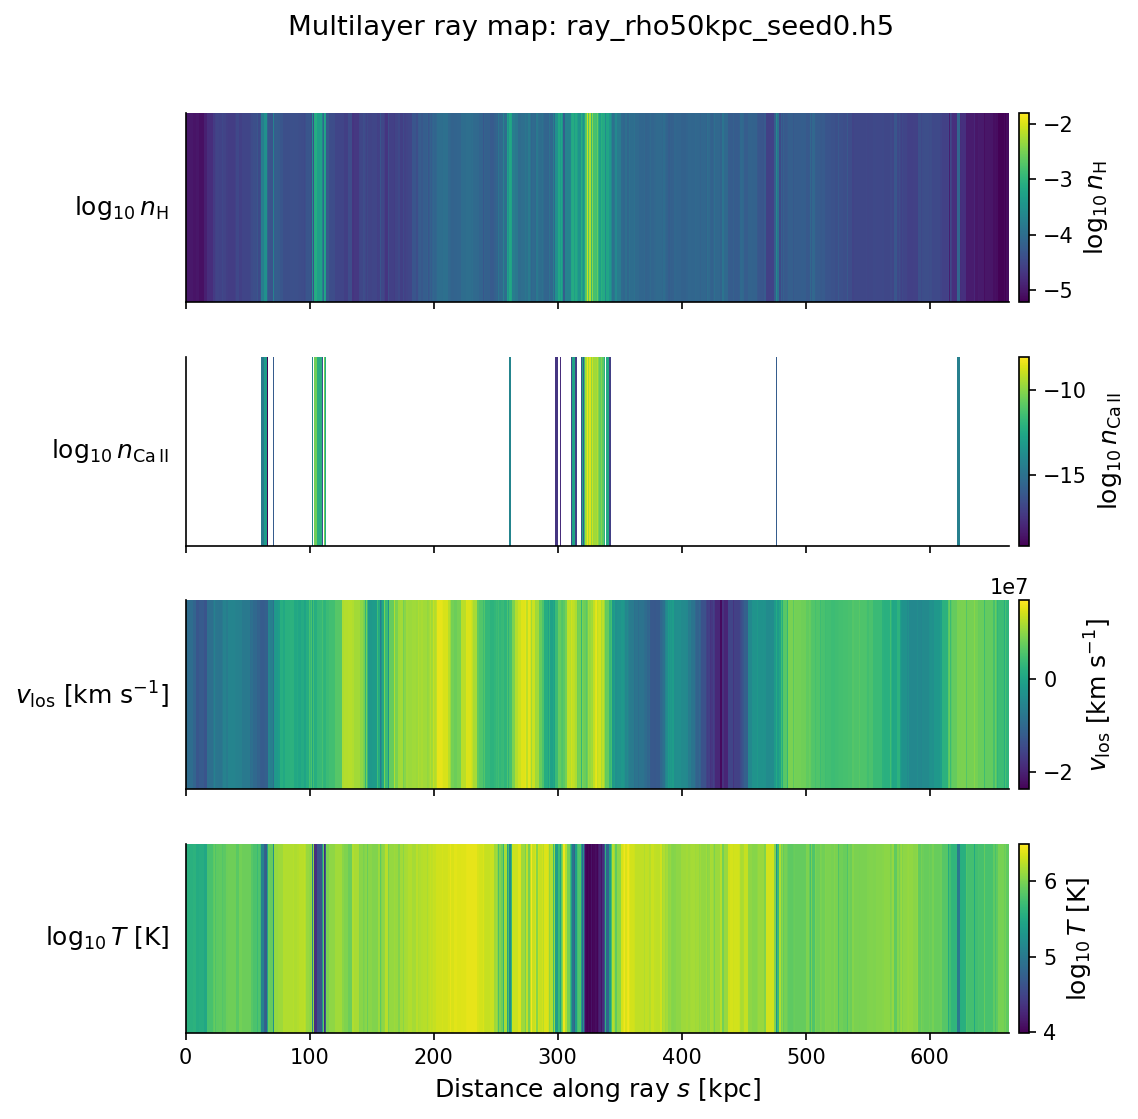

In [5]:

print("=== HDF5 TREE ===")
print_h5_tree(BUNDLE)

series, n_cells, layout = collect_series(
    BUNDLE,
    include_ftypes=INCLUDE_FTYPES,
    include_convenience=True
)
print(f"\nLayout: {layout} ; n_cells={n_cells} ; series={len(series)}")
for s in series:
    print(f" - {s['path']}  (unit='{s['unit']}', N={s['data'].size})")

# Optional: comment this out if you don't want the old per-cell panels
# print("\n=== Plotting per-cell series ===")
# plot_all_series(series, bundle_name=os.path.basename(BUNDLE),
#                 page_size=PAGE_SIZE, save_dir=SAVE_DIR)

# New multilayer 2D ray map
plot_ray_multilayer_map(
    BUNDLE,
    distance_unit="kpc",   # or "cell" if you prefer
    save_path=None         # or "/path/to/ray_multilayer.png"
)

{20.0: {'theta': np.float64(4.218710134820579),
  'N': 453724055649.5685,
  'rayfile': '/Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/ray_ref_rho20kpc_th241.h5',
  'dxdy': (np.float64(-6.41997176734649), np.float64(-11.930306645449164))},
 50.0: {'theta': np.float64(1.1918105463618422),
  'N': 417491381095.9368,
  'rayfile': '/Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/ray_ref_rho50kpc_th68.h5',
  'dxdy': (np.float64(12.531167009660075), np.float64(31.466592472030516))},
 100.0: {'theta': np.float64(0.057346532565527575),
  'N': 26517944642.59387,
  'rayfile': '/Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/ray_ref_rho100kpc_th3.h5',
  'dxdy': (np.float64(67.62863561623004), np.float64(3.8825247438416013))}}

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Na I D + Ca II H&K:
- Three rays at impact parameters 20/50/100 kpc
    • 20 kpc: random position angle (reproducible by SEED)
    • 50/100 kpc: use user-specified start/end offsets (dx, dy) in code_length
- Spectra with two zoomed 2×2 figures per ray:
    (1) wavelength space (±3 Å around line center)
    (2) velocity space (±500 km/s around systemic)
- Ion-weighted and unweighted LOS-velocity projection maps with pierce points
"""

import numpy as np, yt, trident, matplotlib.pyplot as plt, h5py, os
from pathlib import Path
from src.tngmw.config import RAW, PLOTS

# ------------------------------------------------------------------
# Config
# ------------------------------------------------------------------
SEED = 1  # reproducible randomness for the 20 kpc sightline only
rng  = np.random.default_rng(SEED)

CUTOUT = RAW / "subhalo_432106_cutout_full.hdf5"
OUTDIR = (PLOTS / "spectra"); OUTDIR.mkdir(parents=True, exist_ok=True)

# Central wavelengths (vacuum/air distinction is negligible at this level for plotting)
LINE_INFO = [
    ("Na I 5890", "Na I D2", 5889.95095),
    ("Na I 5896", "Na I D1", 5895.92424),
    ("Ca II 3934", "Ca II K", 3933.66300),
    ("Ca II 3968", "Ca II H", 3968.46900),
]
LINE_NAMES_TRIDENT = [li[0] for li in LINE_INFO]
LAM0 = {li[0]: li[2] for li in LINE_INFO}  # map Trident name -> λ0 [Å]

# plot windows
WAVE_HALF_A = 3.0
VEL_HALF_KMS = 500.0
C_KMS = 299_792.458

# sightline geometry
radii_kpc = [20.0, 50.0, 100.0]
Lz_kpc = 350.0  # half-path length

# ------------------------------------------------------------------
# Load dataset, add fields
# ------------------------------------------------------------------
ds = yt.load(CUTOUT)
trident.add_ion_fields(ds, ions=["Na I", "Ca II"])

# IMPORTANT: pos_x, pos_y, pos_z must already be defined (ckpc/h, i.e. code_length here)
# e.g. center = ds.arr([pos_x, pos_y, pos_z], "code_length")
center = ds.arr([pos_x, pos_y, pos_z], "code_length")

ckpc_to_cl = ds.quan(1.0, "kpc").to("code_length").value
dz = Lz_kpc * ckpc_to_cl

# ------------------------------------------------------------------
# Fixed offsets for r=50,100 kpc (provided; already in code_length units)
# ------------------------------------------------------------------
# Keys are radii in kpc; values are (dx_cl, dy_cl) in code_length units
FIXED_OFFSETS = {
    50.0:  (np.float64(12.531167009660075), np.float64(31.466592472030516)),
    100.0: (np.float64(67.62863561623004),  np.float64(3.8825247438416013)),
}
FIXED_THETAS_DEG = {
    50.0:  float(np.degrees(np.float64(1.1918105463618422))),
    100.0: float(np.degrees(np.float64(0.057346532565527575))),
}

# ------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------
def get_offsets_for_radius(r_kpc: float, theta_rand: float | None = None):
    """
    Return (dx_cl, dy_cl) in code_length for the requested impact parameter.
    For 50/100 kpc: use fixed offsets provided by the user.
    For others (e.g. 20 kpc): use theta_rand to compute offsets from r_kpc.
    """
    if r_kpc in FIXED_OFFSETS:
        return FIXED_OFFSETS[r_kpc]
    if theta_rand is None:
        raise ValueError("theta_rand must be provided for radii without fixed offsets")
    dx = r_kpc * np.cos(theta_rand) * ckpc_to_cl
    dy = r_kpc * np.sin(theta_rand) * ckpc_to_cl
    return dx, dy

def endpoints_from_offsets(c, dx_cl, dy_cl, dz_cl):
    p0 = c + ds.arr([dx_cl, dy_cl, -dz_cl], "code_length")
    p1 = c + ds.arr([dx_cl, dy_cl,  dz_cl], "code_length")
    return p0, p1

def make_zoom_figs(tag, lam, flux):
    """Produce two 2×2 figures: wavelength-zoom and velocity-zoom."""
    # Build per-line slices
    wave_panels = []
    vel_panels  = []
    for trident_name, pretty, lam0 in LINE_INFO:
        # wavelength mask
        m = (lam >= lam0 - WAVE_HALF_A) & (lam <= lam0 + WAVE_HALF_A)
        lw, fw = lam[m], flux[m]

        # velocity transform and mask (centered at lam0)
        v = C_KMS * (lam/lam0 - 1.0)
        mv = (v >= -VEL_HALF_KMS) & (v <= +VEL_HALF_KMS)
        lv, fv = v[mv], flux[mv]

        wave_panels.append((pretty, lam0, lw, fw))
        vel_panels.append((pretty, lam0, lv, fv))

    # --- wavelength zooms (2×2) ---
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
    axes = axes.ravel()
    for ax, (pretty, lam0, lw, fw) in zip(axes, wave_panels):
        ax.plot(lw, fw, lw=0.9)
        ax.axvline(lam0, ls="--", lw=0.8)
        ax.set_xlim(lam0 - WAVE_HALF_A, lam0 + WAVE_HALF_A)
        ax.set_title(pretty)
        ax.set_xlabel("Wavelength [Å]")
        ax.grid(alpha=0.3)
    axes[0].set_ylabel("Normalized Flux")
    axes[2].set_ylabel("Normalized Flux")
    fig.tight_layout()
    fig.savefig(OUTDIR / f"{tag}_zoom_wavelength.png", dpi=160)
    plt.close(fig)

    # --- velocity zooms (2×2) ---
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
    axes = axes.ravel()
    for ax, (pretty, lam0, lv, fv) in zip(axes, vel_panels):
        ax.plot(lv, fv, lw=0.9)
        ax.axvline(0.0, ls="--", lw=0.8)
        ax.set_xlim(-VEL_HALF_KMS, +VEL_HALF_KMS)
        ax.set_title(pretty)
        ax.set_xlabel("Velocity [km s$^{-1}$]")
        ax.grid(alpha=0.3)
    axes[0].set_ylabel("Normalized Flux")
    axes[2].set_ylabel("Normalized Flux")
    fig.tight_layout()
    fig.savefig(OUTDIR / f"{tag}_zoom_velocity.png", dpi=160)
    plt.close(fig)

# ------------------------------------------------------------------
# Spectra per ray + zoom plots
#   - 20 kpc uses random PA;
#   - 50/100 kpc use fixed (dx, dy) in code_length from the user
# ------------------------------------------------------------------
# store the pierce-point offsets actually used for later annotations
used_offsets = {}

for r in radii_kpc:
    if r in FIXED_OFFSETS:
        dx_cl, dy_cl = get_offsets_for_radius(r, theta_rand=None)
        theta_used = FIXED_THETAS_DEG[r]
        tag = f"rho{int(r)}kpc_fixed"
    else:
        theta = rng.uniform(0.0, 2.0*np.pi)
        dx_cl, dy_cl = get_offsets_for_radius(r, theta_rand=theta)
        theta_used = np.degrees(theta)
        tag = f"rho{int(r)}kpc_seed{SEED}"

    used_offsets[r] = (dx_cl, dy_cl)

    p0, p1 = endpoints_from_offsets(center, dx_cl, dy_cl, dz)
    rayfile = OUTDIR / f"ray_{tag}.h5"

    # Build ray and write to HDF5
    _ = trident.make_simple_ray(
        ds,
        start_position=p0, end_position=p1,
        data_filename=str(rayfile),
        lines=LINE_NAMES_TRIDENT,
        ftype="gas"
    )

    # Rewrite redshift fields inside the HDF5 file: Δz=z_eff−z; set z=0
    with h5py.File(rayfile, "r+") as f:
        if "grid" not in f:
            raise RuntimeError(f"{rayfile} has no /grid group")
        g = f["grid"]
        if ("redshift" in g) and ("redshift_eff" in g):
            z     = g["redshift"][:]
            z_eff = g["redshift_eff"][:]
            g["redshift_eff"][:] = z_eff - z   # Δz
            g["redshift"][:]     = 0.0         # set z = 0

        # Report integrated columns (Na I, Ca II)
        if ("Na_p0_number_density" in g) and ("dl" in g):
            N_NaI  = float(np.nansum(g["Na_p0_number_density"][:] * g["dl"][:]))
        else:
            N_NaI = np.nan
        if ("Ca_p1_number_density" in g) and ("dl" in g):
            N_CaII = float(np.nansum(g["Ca_p1_number_density"][:] * g["dl"][:]))
        else:
            N_CaII = np.nan

    print(f"[r={r:5.1f} kpc | θ={theta_used:6.2f}°]  "
          f"N(Na I)={N_NaI:.3e} cm^-2  N(Ca II)={N_CaII:.3e} cm^-2  -> {rayfile.name}")

    # Reload as yt dataset and make spectrum
    ray_ds = yt.load(str(rayfile))
    sg = trident.SpectrumGenerator(lambda_min=3500.0, lambda_max=6000.0, dlambda=0.01)
    sg.make_spectrum(ray_ds, lines=LINE_NAMES_TRIDENT)
    lam = np.asarray(sg.lambda_field); flux = np.asarray(sg.flux_field)
    make_zoom_figs(tag, lam, flux)

# ------------------------------------------------------------------
# Ion-weighted LOS-velocity projections (mean v_los) and unweighted SPH view
# ------------------------------------------------------------------
vel_field = ("gas", "velocity_z")   # default units: cm/s

fields = {
    "Na I": ("gas", "Na_p0_number_density"),
    "Ca II": ("gas", "Ca_p1_number_density"),
    "Gas":  ("gas", "density"),
}

for name, ion_ndens in fields.items():
    p = yt.ProjectionPlot(
        ds, "z", vel_field,
        center=center, width=(250.0, "kpc"),
        weight_field=ion_ndens  # ⟨v_z⟩ weighted by ion density or gas density
    )
    p.set_unit(vel_field, "km/s")
    p.set_cmap(vel_field, "RdBu")
    p.set_zlim(vel_field, -200.0, 200.0)

    # pierce points from used_offsets
    for r in radii_kpc:
        dx_cl, dy_cl = used_offsets[r]
        mark3d = [center[0].value + dx_cl, center[1].value + dy_cl, center[2].value]
        p.annotate_marker(
            mark3d,
            coord_system="data",
            marker="x",
            plot_args={"color": "black", "s": 64, "linewidths": 1.4}
        )
        p.annotate_text(
            mark3d, f"{int(r)} kpc",
            coord_system="data",
            text_args={"color": "black", "fontsize": 12, "weight": "bold"}
        )

    p.annotate_title(f"{name} weighted ⟨v_los⟩ (axis=z)")
    p.save(OUTDIR / f"proj_{name.replace(' ','_')}_vlos_weighted_seed{SEED}.png")

# Unweighted SPH-style velocity projection (mean per pixel without ion weighting)
def vlos_projection(axis="z", width_kpc=250.0, vabs_kms=400.0, cmap="RdBu"):
    vel = ("gas", f"velocity_{axis}")
    p = yt.ParticleProjectionPlot(
        ds, axis, vel,
        center=center, width=(width_kpc, "kpc"),
        weight_field=None,
    )
    p.set_unit(vel, "km/s")
    p.set_cmap(vel, cmap)
    p.set_zlim(vel, -vabs_kms, +vabs_kms)

    for r in radii_kpc:
        dx_cl, dy_cl = used_offsets[r]
        mark3d = [center[0].value + dx_cl, center[1].value + dy_cl, center[2].value]
        p.annotate_marker(
            mark3d, coord_system="data", marker="x",
            plot_args={"color": "black", "s": 64, "linewidths": 1.4},
        )
        p.annotate_text(
            mark3d, f"{int(r)} kpc",
            coord_system="data",
            text_args={"color": "black", "fontsize": 12, "weight": "bold"},
        )

    p.annotate_title(rf"Unweighted LOS Velocity (v$_{{\rm {axis}}}$)")
    return p

proj = vlos_projection(axis="z", width_kpc=250.0, vabs_kms=400.0)
proj.save(OUTDIR / f"proj_vlos_unweighted_z_seed{SEED}.png")

yt : [INFO     ] 2025-11-09 12:39:36,278 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-11-09 12:39:36,306 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-09 12:39:36,307 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-09 12:39:36,307 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-11-09 12:39:36,307 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-11-09 12:39:36,308 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-11-09 12:39:36,309 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-11-09 12:39:36,309 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-11-09 12:39:36,311 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-11-09 12:39:36,311 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-11-09 12:39:36,312 Parameters: hubble_con

[r= 20.0 kpc | θ=184.26°]  N(Na I)=7.949e+10 cm^-2  N(Ca II)=2.754e+14 cm^-2  -> ray_rho20kpc_seed1.h5


Adding line - Ca II 3968 [3968.469000 A]: 100%|██████████| 959/959 [00:00<00:00, 33782.99it/s]
yt : [INFO     ] 2025-11-09 12:39:37,963 Getting segment at z = 2.220446049250313e-16: [0.22586746 0.24625419 0.05655457] unitary to [0.22586746 0.24625419 0.07010257] unitary.
yt : [INFO     ] 2025-11-09 12:39:37,963 Getting subsegment: [0.22586746 0.24625419 0.05655457] unitary to [0.22586746 0.24625419 0.07010257] unitary.
yt : [INFO     ] 2025-11-09 12:39:38,544 Saving field data to yt dataset: /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/ray_rho50kpc_fixed.h5.
yt : [INFO     ] 2025-11-09 12:39:38,555 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-09 12:39:38,555 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-09 12:39:38,556 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-11-09 12:39:38,556 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length


[r= 50.0 kpc | θ= 68.29°]  N(Na I)=4.175e+11 cm^-2  N(Ca II)=6.197e+14 cm^-2  -> ray_rho50kpc_fixed.h5


Adding line - Ca II 3968 [3968.469000 A]: 100%|██████████| 872/872 [00:00<00:00, 27292.04it/s]
yt : [INFO     ] 2025-11-09 12:39:38,998 Getting segment at z = 2.220446049250313e-16: [0.22744168 0.24546607 0.05655457] unitary to [0.22744168 0.24546607 0.07010257] unitary.
yt : [INFO     ] 2025-11-09 12:39:38,999 Getting subsegment: [0.22744168 0.24546607 0.05655457] unitary to [0.22744168 0.24546607 0.07010257] unitary.
yt : [INFO     ] 2025-11-09 12:39:39,706 Saving field data to yt dataset: /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/ray_rho100kpc_fixed.h5.
yt : [INFO     ] 2025-11-09 12:39:39,718 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-09 12:39:39,718 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-09 12:39:39,718 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-11-09 12:39:39,719 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length

[r=100.0 kpc | θ=  3.29°]  N(Na I)=2.652e+10 cm^-2  N(Ca II)=4.241e+13 cm^-2  -> ray_rho100kpc_fixed.h5


Adding line - Ca II 3968 [3968.469000 A]: 100%|██████████| 646/646 [00:00<00:00, 46465.12it/s]
yt : [INFO     ] 2025-11-09 12:39:40,061 xlim = 7808.155011 7977.504989
yt : [INFO     ] 2025-11-09 12:39:40,061 ylim = 8502.755011 8672.104989
yt : [INFO     ] 2025-11-09 12:39:40,062 xlim = 7808.155011 7977.504989
yt : [INFO     ] 2025-11-09 12:39:40,062 ylim = 8502.755011 8672.104989
yt : [INFO     ] 2025-11-09 12:39:40,063 Making a fixed resolution buffer of (('gas', 'velocity_z')) 800 by 800
yt : [INFO     ] 2025-11-09 12:39:41,863 Making a fixed resolution buffer of (('gas', 'Na_p0_number_density')) 800 by 800
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_74061/2064079281.py:233: DeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1
  p.annotate_marker(
yt : [INFO     ] 2025-11-09 12:39:43,676 Saving plot /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/proj_Na_I_vlos_wei

['/Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/proj_vlos_unweighted_z_seed1.png']

In [257]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Publication-quality composite with requested refinements.
"""

from pathlib import Path
import re
import numpy as np
import yt, trident, h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ------------------------- Paths -------------------------
from src.tngmw.config import RAW, PLOTS
CUTOUT = RAW / "subhalo_432106_cutout_full.hdf5"
OUTDIR = (PLOTS / "spectra"); OUTDIR.mkdir(parents=True, exist_ok=True)

# ------------------------- Style -------------------------
mpl.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 320,
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.size": 14,
    "axes.titlesize": 14, "axes.labelsize": 16,
    "xtick.labelsize": 16, "ytick.labelsize": 16, "legend.fontsize": 16,
    "xtick.direction": "in", "ytick.direction": "in",
    "axes.linewidth": 1.7,
})

# ------------------------- Constants & lines -------------------------
C_KMS = 299_792.458
V_MIN, V_MAX = -250.0, 250.0                 # km/s (asymmetric)
V_ABS = max(-V_MIN, V_MAX)                   # = 300 for windowing

# (Trident label, pretty label, rest wavelength [Å])
LINES = [
    ("Ca II 3934", "Ca II K", 3933.66300),
    ("Ca II 3968", "Ca II H", 3968.46900),
    ("Na I 5890",  "Na I D2", 5889.95095),
    ("Na I 5896",  "Na I D1", 5895.92424),
]
LAM0 = {lab: lam0 for (lab, _, lam0) in LINES}
PANEL_ORDER = [
    ("Ca II 3934", "Ca II K"),
    ("Ca II 3968", "Ca II H"),
    ("Na I 5890",  "Na I D2"),
    ("Na I 5896",  "Na I D1"),
]

def pretty_to_mathrm(txt: str) -> str:
    return r"\mathrm{" + txt.replace(" ", r"\ ") + "}"

# radii and distinct colors/markers for sightlines
radii_kpc = [20.0, 50.0, 100.0]
RCOL = {20.0: "#f8e91f", 50.0: "#e312bd", 100.0: "#2ca02c"}
RMRK = {20.0: "x", 50.0: "s", 100.0: "p"}
RIDX = {20.0: 1, 50.0: 2, 100.0: 3}

# Labels
ANN_TEXT = {
    r: rf"\textbf{{#{RIDX[r]}}}\\${int(r)}\,\mathrm{{kpc}}$"
    for r in radii_kpc
}
ANN_TEXT = {r: rf"\textbf{{\#{RIDX[r]}}}\,,${int(r)}\,\mathrm{{kpc}}$" for r in radii_kpc}
LEG_TEXT = {r: rf"\#{RIDX[r]}" for r in radii_kpc}

# ------------------------- Load & fields -------------------------
ds = yt.load(CUTOUT)
trident.add_ion_fields(ds, ions=["Na I", "Ca II"])

# pos_x, pos_y, pos_z must exist upstream
center = ds.arr([pos_x, pos_y, pos_z], "code_length")

ckpc_to_cl = ds.quan(1.0, "kpc").to("code_length").value
Lz_kpc = 350.0
dz = Lz_kpc * ckpc_to_cl

# fixed offsets for 50/100 kpc (already code_length)
FIXED_OFFSETS = {
    50.0:  (np.float64(12.531167009660075), np.float64(31.466592472030516)),
    100.0: (np.float64(67.62863561623004),  np.float64(3.8825247438416013)),
}
SEED = 1
rng  = np.random.default_rng(SEED)

def offsets_for_radius(r_kpc, theta=None):
    if r_kpc in FIXED_OFFSETS:
        return FIXED_OFFSETS[r_kpc]
    if theta is None:
        raise ValueError("theta required for non-fixed radius")
    dx = r_kpc * np.cos(theta) * ckpc_to_cl
    dy = r_kpc * np.sin(theta) * ckpc_to_cl
    return dx, dy

def endpoints(center, dx_cl, dy_cl, dz_cl):
    p0 = center + ds.arr([dx_cl, dy_cl, dz_cl], "code_length")
    p1 = center + ds.arr([dx_cl, dy_cl, - dz_cl], "code_length")
    return p0, p1

# ------------------------- Rays -------------------------
rayfiles = {}
pierce_xy_kpc = {}
for r in radii_kpc:
    if r in FIXED_OFFSETS:
        dx_cl, dy_cl = offsets_for_radius(r)
        tag = f"rho{int(r)}kpc_fixed"
    else:
        theta = rng.uniform(0, 2*np.pi)
        dx_cl, dy_cl = offsets_for_radius(r, theta)
        tag = f"rho{int(r)}kpc_seed{SEED}"
    pierce_xy_kpc[r] = (dx_cl/ckpc_to_cl, dy_cl/ckpc_to_cl)

    p0, p1 = endpoints(center, dx_cl, dy_cl, dz)
    rayfile = OUTDIR / f"ray_{tag}.h5"
    rayfiles[r] = rayfile

    _ = trident.make_simple_ray(
        ds, start_position=p0, end_position=p1,
        data_filename=str(rayfile),
        lines=[lab for (lab, _, _) in LINES],
        ftype="gas",
    )

    # center velocities (z_eff := z_eff - z ; z := 0)
    with h5py.File(rayfile, "r+") as f:
        if "grid" in f and ("redshift" in f["grid"]) and ("redshift_eff" in f["grid"]):
            z  = f["grid"]["redshift"][:]
            ze = f["grid"]["redshift_eff"][:]
            f["grid"]["redshift_eff"][:] = ze - z
            f["grid"]["redshift"][:]     = 0.0

# ------------------------- LEFT: density-weighted <v_los> -------------------------
vel_field   = ("gas", "velocity_z")
WFIELD_DENS = ("gas", "density")
WIDTH = (350.0, "kpc")

pmap = yt.ProjectionPlot(
    ds, "z", vel_field, center=center, width=WIDTH, weight_field=WFIELD_DENS
)
pmap.set_unit(vel_field, "km/s")
pmap.set_cmap(vel_field, "RdBu")
pmap.set_zlim(vel_field, -200.0, 200.0)

frb_v     = pmap.frb
v_img     = frb_v[vel_field].in_units("km/s").v
im_handle = pmap.plots[vel_field].image
extent    = im_handle.get_extent()  # (xmin, xmax, ymin, ymax) in kpc

# ------------------------- RIGHT: single-line velocity spectra -------------------------
def single_line_velocity_spectrum(rayfile_path, trident_label, lam0, v_abs=V_ABS):
    ray_ds = yt.load(str(rayfile_path))
    dlam = lam0 * (v_abs / C_KMS)
    lam_min, lam_max = float(lam0 - dlam), float(lam0 + dlam)
    sg = trident.SpectrumGenerator(lambda_min=lam_min, lambda_max=lam_max, dlambda=0.01)
    sg.make_spectrum(ray_ds, lines=[trident_label])
    lam  = np.asarray(sg.lambda_field, float)
    flux = np.asarray(sg.flux_field,   float)
    v = C_KMS * (lam/lam0 - 1.0)
    m = (v >= V_MIN) & (v <= V_MAX)
    return v[m], flux[m]

spectra = {}
for pi, (lab, _pretty) in enumerate(PANEL_ORDER):
    lam0 = LAM0[lab]
    for r in radii_kpc:
        v, f = single_line_velocity_spectrum(rayfiles[r], lab, lam0, v_abs=V_ABS)
        spectra[(pi, r)] = (v, f)

# ------------------------- Figure & grids -------------------------
fig = plt.figure(figsize=(13.6, 6.8))

# Outer grid: 1×2 (space between panels via wspace)
outer = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1.2, 1.25], wspace=0.12)

# Left panel
left_gs = outer[0, 0].subgridspec(nrows=1, ncols=1)
axL = fig.add_subplot(left_gs[0, 0])
im = axL.imshow(v_img, origin="lower", extent=extent, cmap="RdBu",
                vmin=-200.0, vmax=+200.0, interpolation="bilinear", alpha=1, zorder=1)


MS = {20.0: 11.5, 50.0: 11.5, 100.0: 11.5}      # marker sizes
EDGEW = {"s": 2.0, "D": 2.0}                    # edge widths for filled markers
X_OUTER_EW, X_INNER_EW = 3.2, 2.0               # edge widths for layered 'x'

# sightline markers + semi-transparent boxed labels above markers
for r in radii_kpc:
    xk, yk = pierce_xy_kpc[r]
    mk = RMRK[r]

    if mk == "x":
        # outer black X (slightly larger)
        axL.plot(xk, yk, marker="x", linestyle="None",
                 markersize=MS[r] + 1.8, markeredgewidth=X_OUTER_EW,
                 color="k", zorder=3)
        # inner colored X
        axL.plot(xk, yk, marker="x", linestyle="None",
                 markersize=MS[r], markeredgewidth=X_INNER_EW,
                 color=RCOL[r], zorder=4)
    else:
        # filled markers with black edge
        axL.plot(xk, yk, marker=mk, linestyle="None",
                 markersize=MS[r],
                 markerfacecolor=RCOL[r],
                 markeredgecolor="k",
                 markeredgewidth=EDGEW.get(mk, 2.0),
                 zorder=4)
    axL.annotate(
        ANN_TEXT[r],
        xy=(xk, yk), xycoords="data",
        xytext=(0, 10), textcoords="offset points",
        ha="center", va="bottom", color="black",
        fontsize=16,
        bbox=dict(
            boxstyle="round,pad=0.22",
            facecolor="white", edgecolor="black", alpha=0.25, lw=0.7
        ),
        zorder=5
    )

# top-right info boxes
m = re.search(r"subhalo_(\d+)", str(CUTOUT))
sub_id = m.group(1) if m else "432106"
axL.text(0.96, 0.96, rf"\textbf{{TNG50-1}}\;, ID = {sub_id}",
         fontsize=16,
         transform=axL.transAxes, ha="right", va="top", color="black",
         bbox=dict(boxstyle="round,pad=0.28", facecolor="white", edgecolor="0.5", alpha=0.9), zorder=5)
# place it at bottom-right to avoid overlap with pierce-point labels
axL.text(0.97, 0.09, r"$z = 0,\;\log(M_\star/M_\odot)=11.2$",
            fontsize=16,
         transform=axL.transAxes, ha="right", va="top", color="black",
         bbox=dict(boxstyle="round,pad=0.28", facecolor="white", edgecolor="0.5", alpha=0.9), zorder=5)

# Left panel formatting
axL.set_xlabel(r"$x$ [kpc]", fontsize=24, labelpad=-3)
axL.set_ylabel(r"$y$ [kpc]", fontsize=24, labelpad=-3)
axL.minorticks_on()
axL.tick_params(which="both", direction="in", top=True, right=True, length=6)
axL.tick_params(which="minor", length=3)
# set x tick labels to multiples of 50 kpc and also x tick labels
x_ticks = [-150, -100, -50, 0, 50, 100, 150]
axL.set_xticks(x_ticks)
axL.set_xticklabels([str(x) for x in x_ticks])
axL.set_yticks(x_ticks)
axL.set_yticklabels([str(y) for y in x_ticks])

# Colorbar exactly under left panel
divider = make_axes_locatable(axL)
cax = divider.append_axes("bottom", size="5.5%", pad=0.65)
cb  = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.set_label(r"$\langle v_{\rm los}\rangle$  [km s$^{-1}$]", fontsize=20)
cb.ax.tick_params(direction="in", top=True, bottom=True, length=4, labelsize=16)
cb.ax.minorticks_on()
ticks = [-200, -150, -100, -50, 0, 50, 100, 150, 200]
cb.set_ticks(ticks)
cb.set_ticklabels([str(t) for t in ticks])
 
# Right panel: 2×2 grid (touching)
right_gs = outer[0, 1].subgridspec(nrows=2, ncols=2, wspace=0.05, hspace=0.05)
ax_CaK  = fig.add_subplot(right_gs[0, 0])
ax_CaH  = fig.add_subplot(right_gs[0, 1], sharex=ax_CaK, sharey=ax_CaK)
ax_NaD2 = fig.add_subplot(right_gs[1, 0], sharex=ax_CaK)              # own y-scale for Na
ax_NaD1 = fig.add_subplot(right_gs[1, 1], sharex=ax_CaH, sharey=ax_NaD2)
axes = [ax_CaK, ax_CaH, ax_NaD2, ax_NaD1]

# Draw the four spectra
for ax in axes:
    ax.grid(False)
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True, length=6, pad=3, labelsize=13)
    ax.tick_params(which="minor", length=3, pad=3)

for pi, ax in enumerate(axes):
    lab, pretty = PANEL_ORDER[pi]
    lam0 = LAM0[lab]
    pretty_math = pretty_to_mathrm(pretty)
    for r in radii_kpc:
        v, f = spectra[(pi, r)]
        lbl = LEG_TEXT[r] if pi == 2 else None  # legend handles on bottom-left (Na D2)
        ax.plot(v, f, lw=2, color=RCOL[r], label=lbl)
    ax.axvline(0.0, color="grey", ls="--", lw=0.9, zorder=5)
    ax.set_xlim(V_MIN, V_MAX)
    if "Na I" in lab:
        ax.set_ylim(0.75, 1.03)
        ax.set_yticks([0.8, 0.9, 1.0])
        ax.set_yticklabels([str(y) for y in [0.8, 0.9, 1.0]], fontsize=16)
    else:
        ax.set_ylim(-0.23, 1.1)
        ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels([str(y) for y in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]], fontsize=16)
    ax.text(0.98, 0.05, rf"${pretty_math}\ ({lam0:.0f}\,\AA)$",
            transform=ax.transAxes, ha="right", va="bottom",
            color="#303030",
            fontsize=13,
            bbox=dict(boxstyle="round,pad=0.24", facecolor="white", edgecolor="0.3", alpha=0.85),zorder=4)

# Tick-label visibility rules
ax_CaK.tick_params(labelleft=True);  ax_CaH.tick_params(labelleft=False)
ax_NaD2.tick_params(labelleft=True); ax_NaD1.tick_params(labelleft=False)
ax_CaK.tick_params(labelbottom=False); ax_CaH.tick_params(labelbottom=False)
ax_NaD2.tick_params(labelbottom=True); ax_NaD1.tick_params(labelbottom=True)
for ax in (ax_NaD2, ax_NaD1):
    ax.set_xticks([-200, -100, 0, 100, 200,])
    ax.set_xticklabels([str(x) for x in [-200, -100, 0, 100, 200]], fontsize=16)

ax_NaD2.text(
    0.93, 0.27, r"$R \rightarrow \infty$",
    transform=ax_NaD2.transAxes,
    ha="right", va="top", color="black",
    fontsize=16,
    bbox=dict(boxstyle="round,pad=0.22", facecolor="white", edgecolor="0.6", alpha=0.85),
    zorder=5
)

# Legend on bottom-left (Na D2)
leg = ax_NaD2.legend(
    loc="center right", ncols=1, frameon=True, fancybox=True, framealpha=0.92,
    edgecolor="0.4", facecolor="white", handlelength=1.8, columnspacing=0.8
)
for txt in leg.get_texts():
    txt.set_usetex(True); txt.set_fontsize(16)

# ------------------------- Geometry: match right block height (incl. left colorbar)
# and preserve the right block aspect ratio by uniform x/y scaling -----------------
fig.tight_layout()
fig.canvas.draw()

# Left union bbox: map + its colorbar
bL_map = axL.get_position()
bL_cb  = cax.get_position()
Ly0 = min(bL_map.y0, bL_cb.y0)
Ly1 = max(bL_map.y1, bL_cb.y1)
Lh  = Ly1 - Ly0  # target height

# Right union bbox (current)
b_tl = ax_CaK.get_position();  b_tr = ax_CaH.get_position()
b_bl = ax_NaD2.get_position(); b_br = ax_NaD1.get_position()
Rx0 = min(b_tl.x0, b_bl.x0); Rx1 = max(b_tr.x1, b_br.x1)
Ry0 = min(b_bl.y0, b_br.y0); Ry1 = max(b_tl.y1, b_tr.y1)
Rh  = Ry1 - Ry0
RcX = 0.5 * (Rx0 + Rx1)  # horizontal center of the right block

# Uniform scale to match heights; apply to both x and y to keep aspect ratio
s = Lh / Rh

def _scale_rect(bb, s, RcX, Ry0, Ly0):
    # scale x about the right-block center; scale y about right-block bottom, then anchor to Ly0
    x0 = RcX + s * (bb.x0 - RcX)
    x1 = RcX + s * (bb.x1 - RcX)
    y0 = Ly0 + s * (bb.y0 - Ry0)
    y1 = Ly0 + s * (bb.y1 - Ry0)
    return [x0, y0, x1 - x0, y1 - y0]

for ax in (ax_CaK, ax_CaH, ax_NaD2, ax_NaD1):
    ax.set_position(_scale_rect(ax.get_position(), s, RcX, Ry0, Ly0))

fig.canvas.draw()

# ------------------------- Common axis labels anchored to the UPDATED right block ----
b_tl = ax_CaK.get_position();  b_tr = ax_CaH.get_position()
b_bl = ax_NaD2.get_position(); b_br = ax_NaD1.get_position()
x0 = min(b_tl.x0, b_bl.x0); x1 = max(b_tr.x1, b_br.x1)
y0 = min(b_bl.y0, b_br.y0); y1 = max(b_tl.y1, b_tr.y1)
cx = 0.5 * (x0 + x1); cy = 0.5 * (y0 + y1)

# Remove any previous fig.text calls if needed, then write:
fig.text(cx, y0 - 0.028, r"Velocity  [km s$^{-1}$]", ha="center", va="top", fontsize=22)
fig.text(x0 - 0.028, cy, "Normalized Flux", rotation="vertical",
         ha="right", va="center", fontsize=22)

# ------------------------- Save ------------------------------------------------------
outfile = OUTDIR / "fig_kinematics_plus_spectra_pubquality.png"
fig.savefig(outfile, bbox_inches="tight")
plt.close(fig)
print(f"[saved] {outfile}")

yt : [INFO     ] 2025-11-09 19:18:17,978 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-11-09 19:18:17,996 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-09 19:18:17,997 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-09 19:18:17,997 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-11-09 19:18:17,998 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-11-09 19:18:17,998 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-11-09 19:18:17,998 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-11-09 19:18:17,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-11-09 19:18:17,999 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-11-09 19:18:17,999 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-11-09 19:18:18,000 Parameters: hubble_con

[saved] /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/fig_kinematics_plus_spectra_pubquality.png


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Publication-quality composite with enlarged fonts (minimal changes).
"""

from pathlib import Path
import re
import numpy as np
import yt, trident, h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ------------------------- Paths -------------------------
from src.tngmw.config import RAW, PLOTS
CUTOUT = RAW / "subhalo_432106_cutout_full.hdf5"
OUTDIR = (PLOTS / "spectra"); OUTDIR.mkdir(parents=True, exist_ok=True)

# ------------------------- Style (only font sizes changed) -------------------------
mpl.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 320,
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.size": 16,          # was 14
    "axes.titlesize": 18,     # was 14
    "axes.labelsize": 18,     # was 16
    "xtick.labelsize": 16,    # was 13
    "ytick.labelsize": 16,    # was 13
    "legend.fontsize": 15,    # was 13
    "xtick.direction": "in", "ytick.direction": "in",
    "axes.linewidth": 1.4,
})

# ------------------------- Constants & lines -------------------------
C_KMS = 299_792.458
V_MIN, V_MAX = -250.0, 250.0
V_ABS = max(-V_MIN, V_MAX)

LINES = [
    ("Ca II 3934", "Ca II K", 3933.66300),
    ("Ca II 3968", "Ca II H", 3968.46900),
    ("Na I 5890",  "Na I D2", 5889.95095),
    ("Na I 5896",  "Na I D1", 5895.92424),
]
LAM0 = {lab: lam0 for (lab, _, lam0) in LINES}
PANEL_ORDER = [
    ("Ca II 3934", "Ca II K"),
    ("Ca II 3968", "Ca II H"),
    ("Na I 5890",  "Na I D2"),
    ("Na I 5896",  "Na I D1"),
]

def pretty_to_mathrm(txt: str) -> str:
    return r"\mathrm{" + txt.replace(" ", r"\ ") + "}"

# ------------------------- Radii & markers -------------------------
radii_kpc = [20.0, 50.0, 100.0]
RCOL = {20.0: "#f8e91f", 50.0: "#e312bd", 100.0: "#2ca02c"}
RMRK = {20.0: "x", 50.0: "s", 100.0: "p"}
RIDX = {20.0: 1, 50.0: 2, 100.0: 3}

ANN_TEXT = {r: rf"\textbf{{\#{RIDX[r]}}}\,,${int(r)}\,\mathrm{{kpc}}$" for r in radii_kpc}
LEG_TEXT = {r: rf"\#{RIDX[r]}" for r in radii_kpc}

# ------------------------- Load & fields -------------------------
ds = yt.load(CUTOUT)
trident.add_ion_fields(ds, ions=["Na I", "Ca II"])

# pos_x, pos_y, pos_z must exist upstream
center = ds.arr([pos_x, pos_y, pos_z], "code_length")

ckpc_to_cl = ds.quan(1.0, "kpc").to("code_length").value
Lz_kpc = 350.0
dz = Lz_kpc * ckpc_to_cl

# fixed offsets for 50/100 kpc (already code_length)
FIXED_OFFSETS = {
    50.0:  (np.float64(12.531167009660075), np.float64(31.466592472030516)),
    100.0: (np.float64(67.62863561623004),  np.float64(3.8825247438416013)),
}
SEED = 1
rng  = np.random.default_rng(SEED)

def offsets_for_radius(r_kpc, theta=None):
    if r_kpc in FIXED_OFFSETS:
        return FIXED_OFFSETS[r_kpc]
    if theta is None:
        raise ValueError("theta required for non-fixed radius")
    dx = r_kpc * np.cos(theta) * ckpc_to_cl
    dy = r_kpc * np.sin(theta) * ckpc_to_cl
    return dx, dy

def endpoints(center, dx_cl, dy_cl, dz_cl):
    p0 = center + ds.arr([dx_cl, dy_cl, dz_cl], "code_length")
    p1 = center + ds.arr([dx_cl, dy_cl, -dz_cl], "code_length")
    return p0, p1

# ------------------------- Rays -------------------------
rayfiles = {}
pierce_xy_kpc = {}
for r in radii_kpc:
    if r in FIXED_OFFSETS:
        dx_cl, dy_cl = offsets_for_radius(r)
        tag = f"rho{int(r)}kpc_fixed"
    else:
        theta = rng.uniform(0, 2*np.pi)
        dx_cl, dy_cl = offsets_for_radius(r, theta)
        tag = f"rho{int(r)}kpc_seed{SEED}"
    pierce_xy_kpc[r] = (dx_cl/ckpc_to_cl, dy_cl/ckpc_to_cl)

    p0, p1 = endpoints(center, dx_cl, dy_cl, dz)
    rayfile = OUTDIR / f"ray_{tag}.h5"
    rayfiles[r] = rayfile

    _ = trident.make_simple_ray(
        ds, start_position=p0, end_position=p1,
        data_filename=str(rayfile),
        lines=[lab for (lab, _, _) in LINES],
        ftype="gas",
    )

    # center velocities
    with h5py.File(rayfile, "r+") as f:
        if "grid" in f and ("redshift" in f["grid"]) and ("redshift_eff" in f["grid"]):
            z  = f["grid"]["redshift"][:]
            ze = f["grid"]["redshift_eff"][:]
            f["grid"]["redshift_eff"][:] = ze - z
            f["grid"]["redshift"][:]     = 0.0

# ------------------------- LEFT: map -------------------------
vel_field   = ("gas", "velocity_z")
WFIELD_DENS = ("gas", "density")
WIDTH = (350.0, "kpc")

pmap = yt.ProjectionPlot(
    ds, "z", vel_field, center=center, width=WIDTH, weight_field=WFIELD_DENS
)
pmap.set_unit(vel_field, "km/s")
pmap.set_cmap(vel_field, "RdBu")            # unchanged
pmap.set_zlim(vel_field, -200.0, 200.0)

frb_v     = pmap.frb
v_img     = frb_v[vel_field].in_units("km/s").v
im_handle = pmap.plots[vel_field].image
extent    = im_handle.get_extent()

# # ------------------------- RIGHT: spectra -------------------------
# def single_line_velocity_spectrum(rayfile_path, trident_label, lam0, v_abs=V_ABS):
#     ray_ds = yt.load(str(rayfile_path))
#     dlam = lam0 * (v_abs / C_KMS)
#     lam_min, lam_max = float(lam0 - dlam), float(lam0 + dlam)
#     sg = trident.SpectrumGenerator(lambda_min=lam_min, lambda_max=lam_max, dlambda=0.01)
#     sg.make_spectrum(ray_ds, lines=[trident_label])

#     lam  = np.asarray(sg.lambda_field, float)
#     flux = np.asarray(sg.flux_field,   float)
#     v = C_KMS * (lam/lam0 - 1.0)
#     m = (v >= V_MIN) & (v <= V_MAX)
#     return v[m], flux[m]

# ------------------------- RIGHT: spectra -------------------------
def single_line_velocity_spectrum(rayfile_path, trident_label, lam0, v_abs=V_ABS):
    """
    Same API/outputs as before.
    Implements a Gaussian instrumental LSF with FWHM = 70 km/s by
    convolving in wavelength space on an expanded (padded) λ-grid,
    then converts back to velocity and clips to [V_MIN, V_MAX].
    """
    FWHM_KMS = 70.0
    C2SIGMA  = 2.354820045  # FWHM -> sigma

    # --- build spectrum on λ with your original dlambda ---
    ray_ds = yt.load(str(rayfile_path))
    dlam_win = lam0 * (v_abs / C_KMS)                   # half-width for plotting window
    lam_min_core, lam_max_core = float(lam0 - dlam_win), float(lam0 + dlam_win)

    dlambda = 0.1  # Å per pixel (unchanged sampling)

    # --- choose padding from LSF width in Å at lam0 ---
    sigma_v     = FWHM_KMS / C2SIGMA                    # km/s
    sigma_lam0  = lam0 * (sigma_v / C_KMS)              # Å
    pad_sigma   = 6.0                                   # pad by ±6σ in λ to kill edge artifacts
    lam_pad     = pad_sigma * sigma_lam0                # Å
    lam_min, lam_max = lam_min_core - lam_pad, lam_max_core + lam_pad

    # generate spectrum over expanded λ-range
    sg = trident.SpectrumGenerator(lambda_min=lam_min, lambda_max=lam_max, dlambda=dlambda)
    sg.make_spectrum(ray_ds, lines=[trident_label])

    lam  = np.asarray(sg.lambda_field, float)           # uniform-Δλ grid
    flux = np.asarray(sg.flux_field,   float)

    # --- build Gaussian kernel in λ (constant-Δλ grid) ---
    sigma_bins = sigma_lam0 / dlambda                   # σ in pixels (bins)
    half = int(np.ceil(4.0 * sigma_bins))               # ~±4σ support
    if half < 1:
        half = 1
    i   = np.arange(-half, half + 1, dtype=float)
    ker = np.exp(-0.5 * (i / sigma_bins) ** 2)
    ker /= ker.sum()

    # --- pad in λ-space, convolve, then crop back to the core window ---
    pad_width = half
    flux_p = np.pad(flux, pad_width, mode="reflect")
    flux_c = np.convolve(flux_p, ker, mode="same")[pad_width:-pad_width]

    # crop to the *core* λ-range (no padding)
    core = (lam >= lam_min_core) & (lam <= lam_max_core)
    lam_core  = lam[core]
    flux_core = flux_c[core]

    # --- convert to velocity about lam0 and clip to [V_MIN, V_MAX] ---
    v = C_KMS * (lam_core / lam0 - 1.0)                 # km/s
    m = (v >= V_MIN) & (v <= V_MAX)
    return v[m], flux_core[m]

spectra = {}
for pi, (lab, _pretty) in enumerate(PANEL_ORDER):
    lam0 = LAM0[lab]
    for r in radii_kpc:
        v, f = single_line_velocity_spectrum(rayfiles[r], lab, lam0, v_abs=V_ABS)
        spectra[(pi, r)] = (v, f)

# ------------------------- Figure & grids -------------------------
fig = plt.figure(figsize=(13.6, 6.9))  # +0.1 in height to accommodate larger fonts
outer = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1.2, 1.25], wspace=0.12)

# Left panel
axL = fig.add_subplot(outer[0, 0])
im = axL.imshow(v_img, origin="lower", extent=extent, cmap="RdBu",
                vmin=-200.0, vmax=+200.0, interpolation="bilinear", alpha=1, zorder=1)

# marker sizes unchanged
MS = {20.0: 11.5, 50.0: 11.5, 100.0: 11.5}
EDGEW = {"s": 2.0, "D": 2.0}
X_OUTER_EW, X_INNER_EW = 3.2, 2.0

for r in radii_kpc:
    xk, yk = pierce_xy_kpc[r]
    mk = RMRK[r]
    if mk == "x":
        axL.plot(xk, yk, marker="x", linestyle="None",
                 markersize=MS[r] + 1.8, markeredgewidth=X_OUTER_EW,
                 color="k", zorder=3)
        axL.plot(xk, yk, marker="x", linestyle="None",
                 markersize=MS[r], markeredgewidth=X_INNER_EW,
                 color=RCOL[r], zorder=4)
    else:
        axL.plot(xk, yk, marker=mk, linestyle="None",
                 markersize=MS[r],
                 markerfacecolor=RCOL[r],
                 markeredgecolor="k",
                 markeredgewidth=EDGEW.get(mk, 2.0),
                 zorder=4)
    axL.annotate(
        ANN_TEXT[r],
        xy=(xk, yk), xycoords="data",
        xytext=(0, 10), textcoords="offset points",
        ha="center", va="bottom", color="black",
        fontsize=15,  # was 12.5
        bbox=dict(boxstyle="round,pad=0.22", facecolor="white",
                  edgecolor="black", alpha=0.25, lw=0.7),
        zorder=5
    )

# info boxes (slightly larger font)
m = re.search(r"subhalo_(\d+)", str(CUTOUT))
sub_id = m.group(1) if m else "432106"
axL.text(0.98, 0.97, rf"\textbf{{TNG50-1}}\;, ID = {sub_id}",
         transform=axL.transAxes, ha="right", va="top", color="black",
         fontsize=18,
         bbox=dict(boxstyle="round,pad=0.28", facecolor="white", edgecolor="0.5", alpha=0.9), zorder=5)
axL.text(0.98, 0.07, r"$z = 0,\;\log(M_\star/M_\odot)=11.1$",
         transform=axL.transAxes, ha="right", va="top", color="black",
         fontsize=18,
         bbox=dict(boxstyle="round,pad=0.28", facecolor="white", edgecolor="0.5", alpha=0.9), zorder=5)

axL.set_xlabel(r"$x$ [kpc]")
axL.set_ylabel(r"$y$ [kpc]")
axL.minorticks_on()
axL.tick_params(which="both", direction="in", top=True, right=True, length=6)

# Colorbar (same cmap)
divider = make_axes_locatable(axL)
cax = divider.append_axes("bottom", size="5.5%", pad=0.55)
cb  = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.set_label(r"$\langle v_{\rm los}\rangle$  [km s$^{-1}$]", fontsize=18)
cb.ax.tick_params(direction="in", top=True, bottom=True, length=4, labelsize=16)
cb.ax.minorticks_on()

# Right 2×2 grid
right_gs = outer[0, 1].subgridspec(nrows=2, ncols=2, wspace=0.05, hspace=0.05)
ax_CaK  = fig.add_subplot(right_gs[0, 0])
ax_CaH  = fig.add_subplot(right_gs[0, 1], sharex=ax_CaK, sharey=ax_CaK)
ax_NaD2 = fig.add_subplot(right_gs[1, 0], sharex=ax_CaK)
ax_NaD1 = fig.add_subplot(right_gs[1, 1], sharex=ax_CaH, sharey=ax_NaD2)
axes = [ax_CaK, ax_CaH, ax_NaD2, ax_NaD1]

# Draw spectra (line width slightly thicker for larger fonts)
for pi, ax in enumerate(axes):
    lab, pretty = PANEL_ORDER[pi]
    lam0 = LAM0[lab]
    pretty_math = pretty_to_mathrm(pretty)
    for r in radii_kpc:
        v, f = spectra[(pi, r)]
        lbl = LEG_TEXT[r] if pi == 2 else None
        ax.plot(v, f, lw=1.8, color=RCOL[r], label=lbl)
    ax.axvline(0.0, color="k", ls="--", lw=0.9)
    ax.set_xlim(V_MIN, V_MAX)
    if "Na I" in lab:
        ax.set_ylim(0.75, 1.03)
        ax.set_yticks([0.8, 0.9, 1.0])
    else:
        ax.set_ylim(-0.23, 1.1)
        ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    # in-panel line label box: modestly larger, not huge
    ax.text(0.98, 0.05, rf"${pretty_math}\ ({lam0:.0f}\,\AA)$",
            transform=ax.transAxes, ha="right", va="bottom",
            color="#303030",
            fontsize=14,  # was 11
            bbox=dict(boxstyle="round,pad=0.26", facecolor="white", edgecolor="0.3", alpha=0.85),
            zorder=4)

# Tick-label visibility rules unchanged
ax_CaK.tick_params(labelleft=True);  ax_CaH.tick_params(labelleft=False)
ax_NaD2.tick_params(labelleft=True); ax_NaD1.tick_params(labelleft=False)
ax_CaK.tick_params(labelbottom=False); ax_CaH.tick_params(labelbottom=False)
ax_NaD2.tick_params(labelbottom=True); ax_NaD1.tick_params(labelbottom=True)
for ax in (ax_NaD2, ax_NaD1):
    ax.set_xticks([-200, -100, 0, 100, 200])

# R -> ∞ tag, slightly larger
ax_NaD2.text(
    0.93, 0.3, r"$R \rightarrow \infty$",
    transform=ax_NaD2.transAxes,
    ha="right", va="top", color="black",
    fontsize=15,   # was 12
    bbox=dict(boxstyle="round,pad=0.22", facecolor="white", edgecolor="0.6", alpha=0.85),
    zorder=5
)

# Legend (slightly bigger), same location
leg = ax_NaD2.legend(
    loc="center right", ncols=1, frameon=True, fancybox=True, framealpha=0.92,
    edgecolor="0.4", facecolor="white", handlelength=1.8, columnspacing=0.8
)
for txt in leg.get_texts():
    txt.set_usetex(True); txt.set_fontsize(15)

# ------------------------- Geometry block unchanged -------------------------
fig.tight_layout()
fig.canvas.draw()

bL_map = axL.get_position()
bL_cb  = cax.get_position()
Ly0 = min(bL_map.y0, bL_cb.y0)
Ly1 = max(bL_map.y1, bL_cb.y1)
Lh  = Ly1 - Ly0

b_tl = ax_CaK.get_position();  b_tr = ax_CaH.get_position()
b_bl = ax_NaD2.get_position(); b_br = ax_NaD1.get_position()
Rx0 = min(b_tl.x0, b_bl.x0); Rx1 = max(b_tr.x1, b_br.x1)
Ry0 = min(b_bl.y0, b_br.y0); Ry1 = max(b_tl.y1, b_tr.y1)
Rh  = Ry1 - Ry0
RcX = 0.5 * (Rx0 + Rx1)

s = Lh / Rh

def _scale_rect(bb, s, RcX, Ry0, Ly0):
    x0 = RcX + s * (bb.x0 - RcX)
    x1 = RcX + s * (bb.x1 - RcX)
    y0 = Ly0 + s * (bb.y0 - Ry0)
    y1 = Ly0 + s * (bb.y1 - Ry0)
    return [x0, y0, x1 - x0, y1 - y0]

for ax in (ax_CaK, ax_CaH, ax_NaD2, ax_NaD1):
    ax.set_position(_scale_rect(ax.get_position(), s, RcX, Ry0, Ly0))

fig.canvas.draw()

# Common axis labels (slightly larger)
b_tl = ax_CaK.get_position();  b_tr = ax_CaH.get_position()
b_bl = ax_NaD2.get_position(); b_br = ax_NaD1.get_position()
x0 = min(b_tl.x0, b_bl.x0); x1 = max(b_tr.x1, b_br.x1)
y0 = min(b_bl.y0, b_br.y0); y1 = max(b_tl.y1, b_tr.y1)
cx = 0.5 * (x0 + x1); cy = 0.5 * (y0 + y1)

fig.text(cx, y0 - 0.028, r"Velocity  [km s$^{-1}$]", ha="center", va="top", fontsize=20)
fig.text(x0 - 0.030, cy, "Normalized Flux", rotation="vertical",
         ha="right", va="center", fontsize=20)

# ------------------------- Save -------------------------
outfile = OUTDIR / "fig_kinematics_plus_spectra_pubquality_bigfonts.png"
fig.savefig(outfile, bbox_inches="tight")
plt.close(fig)
print(f"[saved] {outfile}")

yt : [INFO     ] 2025-11-11 13:54:54,673 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-11-11 13:54:54,697 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-11 13:54:54,698 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-11 13:54:54,698 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-11-11 13:54:54,698 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-11-11 13:54:54,699 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-11-11 13:54:54,699 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-11-11 13:54:54,699 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-11-11 13:54:54,700 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-11-11 13:54:54,700 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-11-11 13:54:54,700 Parameters: hubble_con

[saved] /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/fig_kinematics_plus_spectra_pubquality_bigfonts.png


## New Set of Sightlines at smaller $\rho$

In [140]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Publication-quality composite with enlarged fonts (formatting preserved).

Implements:
 • Center from TNG API (requires TNG_API_KEY).
 • Disk ellipse fitted to stars within radius = 2 × halfmassrad_stars (from API).
 • Three random sightlines with ρ ≤ 30 kpc, drawn as colored X markers; annotations include ρ.
 • Map width = 60 kpc.
 • Spectra convolved with Gaussian LSF of FWHM = 70 km/s in λ-space on a padded grid.
 • Tick policy: exactly 6 major ticks and 3 minors between majors on both axes of map and all spectra.
"""

from pathlib import Path
import re
import numpy as np
import yt, trident, h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from numpy.linalg import eigh
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LinearLocator, AutoMinorLocator

# ------------------------- Paths & config -------------------------
from src.tngmw.config import RAW, PLOTS, SIMULATION, SNAPNUM, SUBID, TNG_API_KEY
CUTOUT = RAW / "subhalo_432106_cutout_full.hdf5"
OUTDIR = (PLOTS / "spectra"); OUTDIR.mkdir(parents=True, exist_ok=True)

# ------------------------- Style (unchanged) -------------------------
mpl.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 320,
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.size": 16,          # was 14
    "axes.titlesize": 18,     # was 14
    "axes.labelsize": 22,     # was 16
    "xtick.labelsize": 20,    # was 13
    "ytick.labelsize": 20,    # was 13
    "legend.fontsize": 16,    # was 13
    "xtick.direction": "in", "ytick.direction": "in",
    "axes.linewidth": 1.4,
})


# ------------------------- Sightline geometry (random θ; ρ given) -------------------------
rng  = np.random.default_rng(250)

# ------------------------- Constants & lines (unchanged) -------------------------
C_KMS = 299_792.458
V_MIN, V_MAX = -310.0, 310.0
V_ABS = max(-V_MIN, V_MAX)
FWHM_KMS = 70.0  # imposed instrumental resolution for spectra

LINES = [
    ("Ca II 3934", "Ca II K", 3933.66300),
    ("Ca II 3968", "Ca II H", 3968.46900),
    ("Na I 5892",  "Na I D2", 5891.583264),
    ("Na I 5898",  "Na I D1", 5897.566617),
]
LAM0 = {lab: lam0 for (lab, _, lam0) in LINES}
PANEL_ORDER = [
    ("Ca II 3934", "Ca II K"),
    ("Ca II 3968", "Ca II H"),
    ("Na I 5892",  "Na I D2"),
    ("Na I 5898",  "Na I D1"),
]

def pretty_to_mathrm(txt: str) -> str:
    return r"\mathrm{" + txt.replace(" ", r"\ ") + "}"

# ------------------------- Radii & markers (ρ ≤ 30 kpc) -------------------------
radii_kpc = [10.0, 15.0, 25.0]
RCOL = {10.0: "#f8e91f", 15.0: "#e312bd", 25.0: "#2ca02c"}
RIDX = {10.0: 1, 15.0: 2, 25.0: 3}
# ANN_TEXT = {
#     r: rf"\textbf{{\#{RIDX[r]}}}, $\rho={int(r)}\,\mathrm{{kpc}}$"
#     for r in radii_kpc
# }
ANN_TEXT = {
    r: rf"\textbf{{\#{RIDX[r]}}}"
    for r in radii_kpc
}
LEG_TEXT = {r: rf"\#{RIDX[r]}" for r in radii_kpc}

# ------------------------- Load & ion fields -------------------------
ds = yt.load(CUTOUT)
trident.add_ion_fields(ds, ions=["Na I", "Ca II"])

# ------------------------- TNG API helpers -------------------------
def _h():
    # Prefer ds.hubble_constant if present; fallback to Planck-2015 value used by TNG50-1
    return float(getattr(ds, "hubble_constant", 0.6774))

def get_subhalo_json():
    import requests
    url = f"https://www.tng-project.org/api/{SIMULATION}/snapshots/{SNAPNUM}/subhalos/{SUBID}/"
    r = requests.get(url, headers={"api-key": TNG_API_KEY}, timeout=20)
    r.raise_for_status()
    return r.json()

def get_center_from_tng_api():
    d = get_subhalo_json()
    px, py, pz = d.get("pos_x"), d.get("pos_y"), d.get("pos_z")  # ckpc/h
    if (px is None) or (py is None) or (pz is None):
        return ds.domain_center
    ckpc_to_cl = ds.quan(1.0, "kpc").to("code_length").value
    h = _h()
    # physical kpc at z≈0 from ckpc/h: divide by h
    return ds.arr([px / h * ckpc_to_cl, py / h * ckpc_to_cl, pz / h * ckpc_to_cl], "code_length")

def get_halfmassrad_stars_kpc():
    d = get_subhalo_json()
    r_ckpch = d["halfmassrad_stars"]          # in ckpc/h
    h = _h()
    # physical kpc at z≈0
    return float(r_ckpch / h)

# ------------------------- Center & scale factors -------------------------
try:
    center = get_center_from_tng_api()
    R_half_star_kpc = get_halfmassrad_stars_kpc()
except Exception:
    center = ds.domain_center
    R_half_star_kpc = 10.0  # conservative fallback

print(f"[info] using center = {center.in_units('kpc')} kpc from TNG API")
print(f"[info] using R_half_star = {R_half_star_kpc:.2f} kpc from TNG API")

ckpc_to_cl = ds.quan(1.0, "kpc").to("code_length").value
Lz_kpc = 350.0
dz = Lz_kpc * ckpc_to_cl


def offsets_for_radius(r_kpc, theta):
    dx = r_kpc * np.cos(theta) * ckpc_to_cl
    dy = r_kpc * np.sin(theta) * ckpc_to_cl
    return dx, dy

def endpoints(center, dx_cl, dy_cl, dz_cl):
    p0 = center + ds.arr([dx_cl, dy_cl, dz_cl], "code_length")
    p1 = center + ds.arr([dx_cl, dy_cl, -dz_cl], "code_length")
    return p0, p1

# ------------------------- Rays (ρ ≤ 30 kpc) -------------------------
rayfiles = {}
pierce_xy_kpc = {}
for r in radii_kpc:
    theta = rng.uniform(0, 2*np.pi)
    dx_cl, dy_cl = offsets_for_radius(r, theta)
    pierce_xy_kpc[r] = (dx_cl/ckpc_to_cl, dy_cl/ckpc_to_cl)

    p0, p1 = endpoints(center, dx_cl, dy_cl, dz)
    rayfile = OUTDIR / f"ray_rho{int(r)}kpc.h5"
    rayfiles[r] = rayfile

    _ = trident.make_simple_ray(
        ds, start_position=p0, end_position=p1,
        data_filename=str(rayfile),
        lines=[lab for (lab, _, _) in LINES],
        ftype="gas",
    )

    # center velocities
    with h5py.File(rayfile, "r+") as f:
        if "grid" in f and ("redshift" in f["grid"]) and ("redshift_eff" in f["grid"]):
            z  = f["grid"]["redshift"][:]
            ze = f["grid"]["redshift_eff"][:]
            f["grid"]["redshift_eff"][:] = ze - z
            f["grid"]["redshift"][:]     = 0.0

# ------------------------- LEFT: velocity map (width = 60 kpc) -------------------------
vel_field   = ("gas", "velocity_z")
WFIELD_DENS = ("gas", "density")
WIDTH = (110.0, "kpc")

pmap = yt.ProjectionPlot(
    ds, "z", vel_field, center=center, width=WIDTH, weight_field=WFIELD_DENS
)
pmap.set_unit(vel_field, "km/s")
pmap.set_cmap(vel_field, "RdBu")
pmap.set_zlim(vel_field, -200.0, 200.0)

frb_v     = pmap.frb
v_img     = frb_v[vel_field].in_units("km/s").v
im_handle = pmap.plots[vel_field].image
extent    = im_handle.get_extent()

# ------------------------- Ellipse fit to stellar disk inside 2 × R_half_star -------------------------
def fit_disk_ellipse(ds, center, r_sel_kpc, n_sigma=2.0):
    sp = ds.sphere(center, (r_sel_kpc, "kpc"))
    x = (sp[("PartType4", "particle_position_x")] - center[0]).to("kpc").d
    y = (sp[("PartType4", "particle_position_y")] - center[1]).to("kpc").d
    m = sp[("PartType4", "particle_mass")].to("Msun").d
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(m) & (m > 0)
    x, y, m = x[mask], y[mask], m[mask]
    if x.size < 3 or m.sum() <= 0:
        # fallback: circle of radius r_sel_kpc
        return r_sel_kpc, r_sel_kpc, 0.0
    mx, my = np.average(x, weights=m), np.average(y, weights=m)
    X = np.vstack([x - mx, y - my])      # 2×N
    w = m / m.sum()
    C = (X * w) @ X.T                    # 2×2 weighted covariance
    evals, evecs = eigh(C)               # ascending
    order = np.argsort(evals)[::-1]
    evals, evecs = np.clip(evals[order], 0.0, None), evecs[:, order]
    a_sig = float(np.sqrt(evals[0]))
    b_sig = float(np.sqrt(evals[1])) if evals.size > 1 else a_sig
    angle = float(np.degrees(np.arctan2(evecs[1, 0], evecs[0, 0]))) if evecs.size >= 2 else 0.0
    a = float(n_sigma * a_sig); b = float(n_sigma * b_sig)
    if not np.isfinite(a) or a == 0.0: a = r_sel_kpc
    if not np.isfinite(b) or b == 0.0: b = r_sel_kpc
    return a, b, angle

R_select_kpc = 2.0 * R_half_star_kpc
a_kpc, b_kpc, angle_deg = fit_disk_ellipse(ds, center, r_sel_kpc=R_select_kpc, n_sigma=2.0)

# ------------------------- RIGHT: spectra (LSF in λ-space; outputs unchanged) -------------------------
def single_line_velocity_spectrum(rayfile_path, trident_label, lam0, v_abs=V_ABS):
    """
    Same I/O as before; Gaussian LSF with FWHM = 70 km/s
    via λ-space convolution on a padded uniform-Δλ grid; then to velocity.
    """
    C2SIGMA = 2.354820045
    ray_ds = yt.load(str(rayfile_path))

    dlam_core = lam0 * (v_abs / C_KMS)
    lam_min_core, lam_max_core = float(lam0 - dlam_core), float(lam0 + dlam_core)

    # dlambda = 0.01  # Å/pixel
    
    # Instrument-tied sampling: ~4 samples per FWHM in wavelength space
    FWHM_lam   = lam0 * (FWHM_KMS / C_KMS)      # Å
    dlambda    = max(FWHM_lam / 4.0, 0.02)      # Å per pixel; floor avoids extreme oversampling

    sigma_v     = FWHM_KMS / C2SIGMA
    sigma_lam0  = lam0 * (sigma_v / C_KMS)   # Å
    pad_sigma   = 6.0
    lam_pad     = pad_sigma * sigma_lam0
    lam_min, lam_max = lam_min_core - lam_pad, lam_max_core + lam_pad

    sg = trident.SpectrumGenerator(lambda_min=lam_min, lambda_max=lam_max, dlambda=dlambda)
    sg.make_spectrum(ray_ds, lines=[trident_label])

    lam  = np.asarray(sg.lambda_field, float)
    flux = np.asarray(sg.flux_field,   float)

    sigma_bins = max(sigma_lam0 / dlambda, 1e-6)
    half = int(np.ceil(4.0 * sigma_bins))
    half = max(1, half)
    i   = np.arange(-half, half + 1, dtype=float)
    ker = np.exp(-0.5 * (i / sigma_bins) ** 2); ker /= ker.sum()

    flux_p = np.pad(flux, half, mode="reflect")
    flux_c = np.convolve(flux_p, ker, mode="same")[half:-half]

    core = (lam >= lam_min_core) & (lam <= lam_max_core)
    lam_core  = lam[core]
    flux_core = flux_c[core]

    v = C_KMS * (lam_core / lam0 - 1.0)
    m = (v >= V_MIN) & (v <= V_MAX)
    return v[m], flux_core[m]

# ------------------------- Compute spectra (unchanged API) -------------------------
spectra = {}
for pi, (lab, _pretty) in enumerate(PANEL_ORDER):
    lam0 = LAM0[lab]
    for r in radii_kpc:
        v, f = single_line_velocity_spectrum(rayfiles[r], lab, lam0, v_abs=V_ABS)
        spectra[(pi, r)] = (v, f)

# ------------------------- Figure & grids (formatting preserved) -------------------------
fig = plt.figure(figsize=(13.6, 6.9))  # +0.1 in height to accommodate larger fonts
outer = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1.2, 1.25], wspace=0.12)

# Left panel
axL = fig.add_subplot(outer[0, 0])
im = axL.imshow(v_img, origin="lower", extent=extent, cmap="RdBu",
                vmin=-200.0, vmax=+200.0, interpolation="bilinear", alpha=1, zorder=1)

# ------------------------- ADD: stellar inset (30×30 kpc), cyan-framed, ticks, label -------------------------
# Place this block immediately after drawing the main velocity map on axL.

import h5py
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

STELLAR_GRID = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/processed/grid_subhalo_TNG50-1_99_432106.hdf5"

with h5py.File(STELLAR_GRID, "r") as f:
    if "/grid" not in f or not isinstance(f["/grid"], h5py.Dataset):
        raise RuntimeError("Expected dataset '/grid' not found.")
    arr = f["/grid"][()]  # (1500,1500,3), already colorized

if not (arr.ndim == 3 and arr.shape[-1] == 3):
    raise RuntimeError(f"Expected an RGB array (H,W,3); got {arr.shape}")

img_rgb = arr  # use as-is, no normalization/editing

# Full stellar grid covers 60×60 kpc centered at (0,0) ⇒ (-30,30) each axis
extent_full = (-30.0, 30.0, -30.0, 30.0)
ny, nx = img_rgb.shape[:2]

def world_to_index(x, y, extent, nx, ny):
    xmin, xmax, ymin, ymax = extent
    ix = (x - xmin) / (xmax - xmin) * (nx - 1)
    iy = (y - ymin) / (ymax - ymin) * (ny - 1)
    return ix, iy

# Centered 30×30 kpc crop in the *stellar* image
crop_w = crop_h = 30.0
cx = cy = 0.0
crop_extent = (cx - 0.5*crop_w, cx + 0.5*crop_w, cy - 0.5*crop_h, cy + 0.5*crop_h)
ix0, iy0 = world_to_index(crop_extent[0], crop_extent[2], extent_full, nx, ny)
ix1, iy1 = world_to_index(crop_extent[1], crop_extent[3], extent_full, nx, ny)
slx = slice(int(np.floor(min(ix0, ix1))), int(np.ceil(max(ix0, ix1))) + 1)
sly = slice(int(np.floor(min(iy0, iy1))), int(np.ceil(max(iy0, iy1))) + 1)
img_crop = img_rgb[sly, slx, :]

# Desired on-map placement: inset center at (-37.5, -37.5), spanning 30×30 kpc
inset_cx, inset_cy = -37.5, -37.5
half_w = half_h = 0.5 * crop_w
# Bounds of the inset in the PARENT's DATA coordinates
bounds_data = [inset_cx - half_w, inset_cy - half_h, crop_w, crop_h]  # [x0, y0, width, height] in kpc

# Guarantee memory layout only (no value change)
img_crop = np.ascontiguousarray(img_crop)

# Inset axes (unchanged placement)
axin = inset_axes(
    axL, width="100%", height="100%",
    bbox_to_anchor=bounds_data, bbox_transform=axL.transData, borderpad=0
)

# Cyan frame
for side in ("left", "right", "top", "bottom"):
    axin.spines[side].set_color("#00bcd4")
    axin.spines[side].set_linewidth(1.4)
axin.set_facecolor("none")

# Exact extent so inset coords in kpc match ±half_w/half_h
axin.set_xlim(-half_w, half_w)
axin.set_ylim(-half_h, half_h)
axin.set_aspect("equal", adjustable="box")  # avoid stretching

# Render with NO color ops and NO resampling
axin.imshow(
    img_crop, origin="lower",
    extent=(-half_w, half_w, -half_h, half_h),
    interpolation="none",  # no smoothing
    rasterized=False       # keep vector wrapper; pixels remain as-is
)

# Ticks: majors/minors inside; no labels
from matplotlib.ticker import AutoMinorLocator, MaxNLocator
axin.xaxis.set_major_locator(MaxNLocator(5))
axin.yaxis.set_major_locator(MaxNLocator(5))
axin.xaxis.set_minor_locator(AutoMinorLocator(4))
axin.yaxis.set_minor_locator(AutoMinorLocator(4))
axin.tick_params(which="major", direction="in", length=2, width=0.8,
                 top=True, right=True, bottom=True, left=True,
                 labelbottom=False, labelleft=False)
axin.tick_params(which="minor", direction="in", length=1, width=0.6,
                 top=True, right=True, bottom=True, left=True)

# Title centered at top
axin.text(0.5, 1.02, r"\textbf{Stellar Composite}", transform=axin.transAxes,
          ha="center", va="bottom", fontsize=8, color="black",
          bbox=dict(boxstyle="round,pad=0.25", facecolor="white",
                    edgecolor="0.5", alpha=0.0, lw=0.8),
          zorder=3)

# Ellipse overlay in the inset’s kpc frame (unchanged geometry)
ell_in = Ellipse((0.0, 0.0), width=2*a_kpc, height=2*b_kpc, angle=angle_deg,
                 edgecolor="k", facecolor="none", lw=0.8, linestyle="--", zorder=4,alpha =0.7)
axin.add_patch(ell_in)
# axin.add_patch(Ellipse((0.0, 0.0), width=2*a_kpc, height=2*b_kpc, angle=angle_deg,
#                        edgecolor="w", facecolor="none", lw=0.6, linestyle="--",
#                        alpha=0.5, zorder=3.8))
# X markers (two-stroke) and annotations WITH ρ
# MS = {10.0: 11.5, 15.0: 11.5, 25.0: 11.5}
MS = {10.0: 8.0, 15.0: 8.0, 25.0: 8.0}     # was 11.5

# X_OUTER_EW, X_INNER_EW = 3.2, 2.0
X_OUTER_EW, X_INNER_EW = 3.0, 1.8          # was 3.2, 2.0

for r in radii_kpc:
    xk, yk = pierce_xy_kpc[r]
    axL.plot(xk, yk, marker="x", linestyle="None",
             markersize=MS[r] + 1.8, markeredgewidth=X_OUTER_EW,
             color="k", zorder=3)
    axL.plot(xk, yk, marker="x", linestyle="None",
             markersize=MS[r], markeredgewidth=X_INNER_EW,
             color=RCOL[r], zorder=4)
    axL.annotate(
        ANN_TEXT[r],
        xy=(xk, yk), xycoords="data",
        xytext=(0, 10), textcoords="offset points",
        ha="center", va="bottom", color="black",
        fontsize=15,
        bbox=dict(boxstyle="round,pad=0.22", facecolor="white",
                  edgecolor="black", alpha=0.25, lw=0.7),
        zorder=5
    )

# Ellipse overlay from fit inside 2×R_half_star
ell = Ellipse((0.0, 0.0), width=2*a_kpc, height=2*b_kpc, angle=angle_deg,
              edgecolor="k", facecolor="none", lw=1.2, zorder=3,
              linestyle="--")
axL.add_patch(ell)

# Info boxes (unchanged)
m = re.search(r"subhalo_(\d+)", str(CUTOUT))
sub_id = m.group(1) if m else str(SUBID)
axL.text(0.98, 0.97, rf"\textbf{{TNG50-1}}\;, ID = {sub_id}",
         transform=axL.transAxes, ha="right", va="top", color="black",
         fontsize=18,
         bbox=dict(boxstyle="round,pad=0.28", facecolor="white", edgecolor="0.5", alpha=0.7), zorder=5)
axL.text(0.98, 0.07, r"$z = 0,\;\log(M_\star/M_\odot)=11.1$",
         transform=axL.transAxes, ha="right", va="top", color="black",
         fontsize=15,
         bbox=dict(boxstyle="round,pad=0.28", facecolor="white", edgecolor="0.5", alpha=0.7), zorder=5)

axL.set_xlabel(r"$x$ [kpc]",labelpad=-3)
axL.set_ylabel(r"$y$ [kpc]",labelpad=-3)
axL.minorticks_on()
axL.tick_params(which="major", direction="in", top=True, right=True, length=6)
axL.tick_params(which="minor", direction="in", top=True, right=True, length=3)
# set x and y tick labels at -50 to +50 kpc with 
axL.set_xticks([-50,-25,0,25,50])
axL.set_yticks([-50,-25,0,25,50])
# ------ Enforce 6 major and 3 minor ticks on BOTH axes of MAP ------ 
# def apply_locators(ax):
#     ax.xaxis.set_major_locator(LinearLocator(6))
#     ax.yaxis.set_major_locator(LinearLocator(6))
#     ax.xaxis.set_minor_locator(AutoMinorLocator(4))  # 3 minors between majors
#     ax.yaxis.set_minor_locator(AutoMinorLocator(4))

# apply_locators(axL)

# Colorbar (unchanged)
divider = make_axes_locatable(axL)
cax = divider.append_axes("bottom", size="5.5%", pad=0.58)
cb  = fig.colorbar(im, cax=cax, orientation="horizontal")
# cb.set_label(r"$\langle v_{\rm los}^{\mathrm{gas}}\rangle$  [km s$^{-1}$]", fontsize=20)
cb.set_label(r"$\langle v_{\mathrm{los}}\rangle_{\rho_{\mathrm{gas}}}$  [km s$^{-1}$]", fontsize=20)
cb.ax.tick_params(direction="in", top=True, bottom=True, length=4, labelsize=16)
cb.ax.minorticks_on()

# Right 2×2 grid (unchanged layout)
right_gs = outer[0, 1].subgridspec(nrows=2, ncols=2, wspace=0.05, hspace=0.05)
ax_CaK  = fig.add_subplot(right_gs[0, 0])
ax_CaH  = fig.add_subplot(right_gs[0, 1], sharex=ax_CaK, sharey=ax_CaK)
ax_NaD2 = fig.add_subplot(right_gs[1, 0], sharex=ax_CaK)
ax_NaD1 = fig.add_subplot(right_gs[1, 1], sharex=ax_CaH, sharey=ax_NaD2)
axes = [ax_CaK, ax_CaH, ax_NaD2, ax_NaD1]

# Draw spectra (formatting preserved)
for pi, ax in enumerate(axes):
    lab, pretty = PANEL_ORDER[pi]
    lam0 = LAM0[lab]
    pretty_math = pretty_to_mathrm(pretty)
    for r in radii_kpc:
        v, f = spectra[(pi, r)]
        lbl = LEG_TEXT[r] if pi == 3 else None
        # ax.plot(v, f, lw=1.8, color=RCOL[r], label=lbl)
        ax.step(v, f, where="mid", linewidth=1.8, color=RCOL[r], label=lbl)
    ax.axvline(0.0, color="k", ls="--", lw=0.9)
    ax.set_xlim(V_MIN, V_MAX)
    if "Na I" in lab:
        ax.set_ylim(0.75, 1.03)
        ax.set_yticks([0.8, 0.9, 1.0])
    else:
        ax.set_ylim(-0.23, 1.1)
        ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.text(0.98, 0.05, rf"${pretty_math}\ ({lam0:.0f}\,\AA)$",
            transform=ax.transAxes, ha="right", va="bottom",
            color="#303030", fontsize=14,
            bbox=dict(boxstyle="round,pad=0.26", facecolor="white", edgecolor="0.3", alpha=0.85),
            zorder=4)


# ------ Enforce 6 major and 3 minor ticks on BOTH axes of ALL spectra subplots ------
for ax in axes:
    # apply_locators(ax)
    ax.minorticks_on()
    ax.tick_params(which="major", direction="in", top=True, right=True, length=6)
    ax.tick_params(which="minor", direction="in", top=True, right=True, length=3)

# Tick-label visibility rules (unchanged)
ax_CaK.tick_params(labelleft=True);  ax_CaH.tick_params(labelleft=False)
ax_NaD2.tick_params(labelleft=True); ax_NaD1.tick_params(labelleft=False)
ax_CaK.tick_params(labelbottom=False); ax_CaH.tick_params(labelbottom=False)
ax_NaD2.tick_params(labelbottom=True); ax_NaD1.tick_params(labelbottom=True)

for ax in (ax_NaD2, ax_NaD1):
    ax.set_xticks([ -200, -100, 0, 100, 200])
    # set the size of x tick labels small
    for label in ax.get_xticklabels():
            label.set_fontsize(14)

# Resolution tag
R_val = int(round(C_KMS / FWHM_KMS))
# R_val = round of to closest 100
R_val = int(round(R_val / 100.0) * 100)
ax_NaD1.text(
    0.93, 0.27, rf"$R \sim {R_val}$",
    transform=ax_NaD1.transAxes,
    ha="right", va="top", color="black",
    fontsize=15,
    bbox=dict(boxstyle="round,pad=0.22", facecolor="white", edgecolor="0.6", alpha=0.85),
    zorder=5
)

# Legend (unchanged)
leg = ax_NaD1.legend(
    loc="center right", ncols=1, frameon=True, fancybox=True, framealpha=0.92,
    edgecolor="0.4", facecolor="white", handlelength=1.8, columnspacing=0.8
)
for txt in leg.get_texts():
    txt.set_usetex(True); txt.set_fontsize(15)

# ------------------------- Geometry block (unchanged) -------------------------
fig.tight_layout()
fig.canvas.draw()

bL_map = axL.get_position()
bL_cb  = cax.get_position()
Ly0 = min(bL_map.y0, bL_cb.y0)
Ly1 = max(bL_map.y1, bL_cb.y1)
Lh  = Ly1 - Ly0

b_tl = ax_CaK.get_position();  b_tr = ax_CaH.get_position()
b_bl = ax_NaD2.get_position(); b_br = ax_NaD1.get_position()
Rx0 = min(b_tl.x0, b_bl.x0); Rx1 = max(b_tr.x1, b_br.x1)
Ry0 = min(b_bl.y0, b_br.y0); Ry1 = max(b_tl.y1, b_tr.y1)
Rh  = Ry1 - Ry0
RcX = 0.5 * (Rx0 + Rx1)

s = Lh / Rh

def _scale_rect(bb, s, RcX, Ry0, Ly0):
    x0 = RcX + s * (bb.x0 - RcX)
    x1 = RcX + s * (bb.x1 - RcX)
    y0 = Ly0 + s * (bb.y0 - Ry0)
    y1 = Ly0 + s * (bb.y1 - Ry0)
    return [x0, y0, x1 - x0, y1 - y0]

for ax in (ax_CaK, ax_CaH, ax_NaD2, ax_NaD1):
    ax.set_position(_scale_rect(ax.get_position(), s, RcX, Ry0, Ly0))

fig.canvas.draw()

# Common axis labels (unchanged)
b_tl = ax_CaK.get_position();  b_tr = ax_CaH.get_position()
b_bl = ax_NaD2.get_position(); b_br = ax_NaD1.get_position()
x0 = min(b_tl.x0, b_bl.x0); x1 = max(b_tr.x1, b_br.x1)
y0 = min(b_bl.y0, b_br.y0); y1 = max(b_tl.y1, b_tr.y1)
cx = 0.5 * (x0 + x1); cy = 0.5 * (y0 + y1)

fig.text(cx, y0 - 0.03, r"Velocity  [km s$^{-1}$]", ha="center", va="top", fontsize=20)
fig.text(x0 - 0.030, cy, "Normalized Flux", rotation="vertical",
         ha="right", va="center", fontsize=20)

# ------------------------- Save -------------------------
outfile = OUTDIR / "fig_kinematics_plus_spectra_pubquality_bigfonts.png"
fig.savefig(outfile, bbox_inches="tight")
plt.close(fig)
print(f"[saved] {outfile}")

yt : [INFO     ] 2025-11-11 17:09:28,380 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-11-11 17:09:28,399 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-11 17:09:28,399 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-11 17:09:28,399 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-11-11 17:09:28,400 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-11-11 17:09:28,400 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-11-11 17:09:28,400 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-11-11 17:09:28,401 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-11-11 17:09:28,401 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-11-11 17:09:28,401 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-11-11 17:09:28,401 Parameters: hubble_con

[info] using center = [11651.65338057 12677.04458223  3272.06967818] kpc kpc from TNG API
[info] using R_half_star = 10.94 kpc from TNG API


yt : [INFO     ] 2025-11-11 17:09:30,992 Saving field data to yt dataset: /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/ray_rho10kpc.h5.
yt : [INFO     ] 2025-11-11 17:09:31,004 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-11 17:09:31,005 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-11 17:09:31,005 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-11-11 17:09:31,005 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-11-11 17:09:31,005 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-11-11 17:09:31,006 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-11-11 17:09:31,006 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-11-11 17:09:31,006 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-11-11 17:09:31,006 Parameters: omega_radia

[saved] /Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/plots/spectra/fig_kinematics_plus_spectra_pubquality_bigfonts.png


In [137]:
# ===== Batchable figure generator ===========================================
from pathlib import Path
import os, re, gc
import numpy as np
import yt, trident, h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from numpy.linalg import eigh
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoMinorLocator, MaxNLocator

# Your project config (unchanged)
from src.tngmw.config import RAW, PLOTS, SIMULATION, SNAPNUM, SUBID, TNG_API_KEY

# ------------------------- Styling (unchanged) -------------------------
mpl.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 320,
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.size": 16,
    "axes.titlesize": 18,
    "axes.labelsize": 22,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 16,
    "xtick.direction": "in", "ytick.direction": "in",
    "axes.linewidth": 1.4,
})

C_KMS   = 299_792.458
V_MIN, V_MAX = -300.0, 250.0
V_ABS   = max(-V_MIN, V_MAX)
FWHM_KMS = 70.0

LINES = [
    ("Ca II 3934", "Ca II K", 3933.66300),
    ("Ca II 3968", "Ca II H", 3968.46900),
    ("Na I 5892",  "Na I D2", 5891.583264),
    ("Na I 5898",  "Na I D1", 5897.566617),
]
LAM0 = {lab: lam0 for (lab, _, lam0) in LINES}
PANEL_ORDER = [
    ("Ca II 3934", "Ca II K"),
    ("Ca II 3968", "Ca II H"),
    ("Na I 5892",  "Na I D2"),
    ("Na I 5898",  "Na I D1"),
]

radii_kpc = [10.0, 15.0, 25.0]
RCOL = {10.0: "#f8e91f", 15.0: "#e312bd", 25.0: "#2ca02c"}
RIDX = {10.0: 1, 15.0: 2, 25.0: 3}
ANN_TEXT = {r: rf"\textbf{{\#{RIDX[r]}}}" for r in radii_kpc}
LEG_TEXT = {r: rf"\#{RIDX[r]}" for r in radii_kpc}

def _pretty_to_mathrm(txt: str) -> str:
    return r"\mathrm{" + txt.replace(" ", r"\ ") + "}"

# ------------------------- Core function ------------------------------------
def make_kinematics_plus_spectra(
    seed: int,
    cutout_path: Path = RAW / "subhalo_432106_cutout_full.hdf5",
    outdir: Path   = PLOTS / "spectra" / "batch",
    sim: str       = SIMULATION,
    snap: int      = SNAPNUM,
    subid: int     = SUBID,
    tng_api_key: str = TNG_API_KEY,
    keep_rays: bool = False,
) -> Path:
    """
    Build and save the composite figure for one random sightline configuration.
    Returns the path to the saved PNG.
    """
    outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)

    # ---- Load dataset and ion fields
    ds = yt.load(str(cutout_path))
    trident.add_ion_fields(ds, ions=["Na I", "Ca II"])

    # ---- TNG API helpers (local closures to capture ds)
    def _h():
        return float(getattr(ds, "hubble_constant", 0.6774))

    def get_subhalo_json():
        import requests
        url = f"https://www.tng-project.org/api/{sim}/snapshots/{snap}/subhalos/{subid}/"
        r = requests.get(url, headers={"api-key": tng_api_key}, timeout=20)
        r.raise_for_status()
        return r.json()

    def get_center_from_tng_api():
        d = get_subhalo_json()
        px, py, pz = d.get("pos_x"), d.get("pos_y"), d.get("pos_z")
        if (px is None) or (py is None) or (pz is None):
            return ds.domain_center
        ckpc_to_cl = ds.quan(1.0, "kpc").to("code_length").value
        h = _h()
        return ds.arr([px / h * ckpc_to_cl, py / h * ckpc_to_cl, pz / h * ckpc_to_cl], "code_length")

    def get_halfmassrad_stars_kpc():
        d = get_subhalo_json()
        r_ckpch = d["halfmassrad_stars"]
        return float(r_ckpch / _h())

    # ---- Center, scales
    try:
        center = get_center_from_tng_api()
        R_half_star_kpc = get_halfmassrad_stars_kpc()
    except Exception:
        center = ds.domain_center
        R_half_star_kpc = 10.0

    ckpc_to_cl = ds.quan(1.0, "kpc").to("code_length").value
    Lz_kpc = 350.0
    dz = Lz_kpc * ckpc_to_cl

    def offsets_for_radius(r_kpc, theta):
        dx = r_kpc * np.cos(theta) * ckpc_to_cl
        dy = r_kpc * np.sin(theta) * ckpc_to_cl
        return dx, dy

    def endpoints(center, dx_cl, dy_cl, dz_cl):
        p0 = center + ds.arr([dx_cl, dy_cl, dz_cl], "code_length")
        p1 = center + ds.arr([dx_cl, dy_cl, -dz_cl], "code_length")
        return p0, p1

    # ---- Rays (three radii, random angles from seed)
    rng = np.random.default_rng(seed)
    rayfiles = {}
    pierce_xy_kpc = {}
    tmp_files = []

    for r in radii_kpc:
        theta = rng.uniform(0, 2*np.pi)
        dx_cl, dy_cl = offsets_for_radius(r, theta)
        pierce_xy_kpc[r] = (dx_cl/ckpc_to_cl, dy_cl/ckpc_to_cl)

        p0, p1 = endpoints(center, dx_cl, dy_cl, dz)
        rayfile = outdir / f"__tmp_ray_rho{int(r)}kpc_seed{seed}.h5"
        rayfiles[r] = rayfile
        tmp_files.append(rayfile)

        _ = trident.make_simple_ray(
            ds, start_position=p0, end_position=p1,
            data_filename=str(rayfile),
            lines=[lab for (lab, _, _) in LINES],
            ftype="gas",
        )

        # Center velocities
        with h5py.File(rayfile, "r+") as f:
            if "grid" in f and ("redshift" in f["grid"]) and ("redshift_eff" in f["grid"]):
                z  = f["grid"]["redshift"][:]
                ze = f["grid"]["redshift_eff"][:]
                f["grid"]["redshift_eff"][:] = ze - z
                f["grid"]["redshift"][:]     = 0.0

    # ---- Left map: density-weighted v_los
    vel_field   = ("gas", "velocity_z")
    WFIELD_DENS = ("gas", "density")
    WIDTH       = (110.0, "kpc")

    pmap = yt.ProjectionPlot(ds, "z", vel_field, center=center, width=WIDTH, weight_field=WFIELD_DENS)
    pmap.set_unit(vel_field, "km/s")
    pmap.set_cmap(vel_field, "RdBu")
    pmap.set_zlim(vel_field, -200.0, 200.0)

    frb_v     = pmap.frb
    v_img     = frb_v[vel_field].in_units("km/s").v
    im_handle = pmap.plots[vel_field].image
    extent    = im_handle.get_extent()

    # ---- Ellipse fit
    def fit_disk_ellipse(ds, center, r_sel_kpc, n_sigma=2.0):
        sp = ds.sphere(center, (r_sel_kpc, "kpc"))
        x = (sp[("PartType4", "particle_position_x")] - center[0]).to("kpc").d
        y = (sp[("PartType4", "particle_position_y")] - center[1]).to("kpc").d
        m = sp[("PartType4", "particle_mass")].to("Msun").d
        mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(m) & (m > 0)
        x, y, m = x[mask], y[mask], m[mask]
        if x.size < 3 or m.sum() <= 0:
            return r_sel_kpc, r_sel_kpc, 0.0
        mx, my = np.average(x, weights=m), np.average(y, weights=m)
        X = np.vstack([x - mx, y - my])
        w = m / m.sum()
        C = (X * w) @ X.T
        evals, evecs = eigh(C)
        order = np.argsort(evals)[::-1]
        evals, evecs = np.clip(evals[order], 0.0, None), evecs[:, order]
        a_sig = float(np.sqrt(evals[0])); b_sig = float(np.sqrt(evals[1])) if evals.size > 1 else a_sig
        angle = float(np.degrees(np.arctan2(evecs[1, 0], evecs[0, 0]))) if evecs.size >= 2 else 0.0
        a = float(n_sigma * a_sig); b = float(n_sigma * b_sig)
        if not np.isfinite(a) or a == 0.0: a = r_sel_kpc
        if not np.isfinite(b) or b == 0.0: b = r_sel_kpc
        return a, b, angle

    R_select_kpc = 2.0 * R_half_star_kpc
    a_kpc, b_kpc, angle_deg = fit_disk_ellipse(ds, center, r_sel_kpc=R_select_kpc, n_sigma=2.0)

    # ---- Spectra helper
    def single_line_velocity_spectrum(rayfile_path, trident_label, lam0, v_abs=V_ABS):
        C2SIGMA = 2.354820045
        ray_ds = yt.load(str(rayfile_path))

        dlam_core = lam0 * (v_abs / C_KMS)
        lam_min_core, lam_max_core = float(lam0 - dlam_core), float(lam0 + dlam_core)

        FWHM_lam   = lam0 * (FWHM_KMS / C_KMS)
        dlambda    = max(FWHM_lam / 4.0, 0.02)

        sigma_v     = FWHM_KMS / C2SIGMA
        sigma_lam0  = lam0 * (sigma_v / C_KMS)
        pad_sigma   = 6.0
        lam_pad     = pad_sigma * sigma_lam0
        lam_min, lam_max = lam_min_core - lam_pad, lam_max_core + lam_pad

        sg = trident.SpectrumGenerator(lambda_min=lam_min, lambda_max=lam_max, dlambda=dlambda)
        sg.make_spectrum(ray_ds, lines=[trident_label])

        lam  = np.asarray(sg.lambda_field, float)
        flux = np.asarray(sg.flux_field,   float)

        sigma_bins = max(sigma_lam0 / dlambda, 1e-6)
        half = int(np.ceil(4.0 * sigma_bins)); half = max(1, half)
        i   = np.arange(-half, half + 1, dtype=float)
        ker = np.exp(-0.5 * (i / sigma_bins) ** 2); ker /= ker.sum()

        flux_p = np.pad(flux, half, mode="reflect")
        flux_c = np.convolve(flux_p, ker, mode="same")[half:-half]

        core = (lam >= lam_min_core) & (lam <= lam_max_core)
        lam_core  = lam[core]; flux_core = flux_c[core]

        v = C_KMS * (lam_core / lam0 - 1.0)
        m = (v >= V_MIN) & (v <= V_MAX)
        return v[m], flux_core[m]

    spectra = {}
    for pi, (lab, _pretty) in enumerate(PANEL_ORDER):
        lam0 = LAM0[lab]
        for r in radii_kpc:
            v, f = single_line_velocity_spectrum(rayfiles[r], lab, lam0, v_abs=V_ABS)
            spectra[(pi, r)] = (v, f)

    # ---- Figure
    fig = plt.figure(figsize=(13.6, 6.9))
    outer = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1.2, 1.25], wspace=0.12)

    # Left map
    axL = fig.add_subplot(outer[0, 0])
    im = axL.imshow(v_img, origin="lower", extent=extent, cmap="RdBu",
                    vmin=-200.0, vmax=+200.0, interpolation="bilinear", alpha=1, zorder=1)

    # ---- Stellar inset (30×30 kpc), cyan frame, no color edits
    STELLAR_GRID = RAW / "processed" / "grid_subhalo_TNG50-1_99_432106.hdf5"
    with h5py.File(str(STELLAR_GRID), "r") as f:
        if "/grid" not in f or not isinstance(f["/grid"], h5py.Dataset):
            raise RuntimeError("Expected dataset '/grid' not found.")
        arr = f["/grid"][()]
    if not (arr.ndim == 3 and arr.shape[-1] == 3):
        raise RuntimeError(f"Expected (H,W,3); got {arr.shape}")
    img_rgb = np.ascontiguousarray(arr)

    extent_full = (-30.0, 30.0, -30.0, 30.0)
    ny, nx = img_rgb.shape[:2]
    def world_to_index(x, y, extent, nx, ny):
        xmin, xmax, ymin, ymax = extent
        ix = (x - xmin) / (xmax - xmin) * (nx - 1)
        iy = (y - ymin) / (ymax - ymin) * (ny - 1)
        return ix, iy
    crop_w = crop_h = 30.0
    cx = cy = 0.0
    crop_extent = (cx - 0.5*crop_w, cx + 0.5*crop_w, cy - 0.5*crop_h, cy + 0.5*crop_h)
    ix0, iy0 = world_to_index(crop_extent[0], crop_extent[2], extent_full, nx, ny)
    ix1, iy1 = world_to_index(crop_extent[1], crop_extent[3], extent_full, nx, ny)
    slx = slice(int(np.floor(min(ix0, ix1))), int(np.ceil(max(ix0, ix1))) + 1)
    sly = slice(int(np.floor(min(iy0, iy1))), int(np.ceil(max(iy0, iy1))) + 1)
    img_crop = img_rgb[sly, slx, :]

    inset_cx, inset_cy = -37.5, -37.5
    half_w = half_h = 0.5 * crop_w
    bounds_data = [inset_cx - half_w, inset_cy - half_h, crop_w, crop_h]

    axin = inset_axes(axL, width="100%", height="100%",
                      bbox_to_anchor=bounds_data, bbox_transform=axL.transData, borderpad=0)
    for sd in ("left", "right", "top", "bottom"):
        axin.spines[sd].set_color("#00bcd4"); axin.spines[sd].set_linewidth(1.4)
    axin.set_facecolor("none")
    axin.set_xlim(-half_w, half_w); axin.set_ylim(-half_h, half_h); axin.set_aspect("equal", adjustable="box")
    axin.imshow(img_crop, origin="lower", extent=(-half_w, half_w, -half_h, half_h),
                interpolation="none", rasterized=False)
    axin.xaxis.set_major_locator(MaxNLocator(5)); axin.yaxis.set_major_locator(MaxNLocator(5))
    axin.xaxis.set_minor_locator(AutoMinorLocator(4)); axin.yaxis.set_minor_locator(AutoMinorLocator(4))
    axin.tick_params(which="major", direction="in", length=2, width=0.8,
                     top=True, right=True, bottom=True, left=True,
                     labelbottom=False, labelleft=False)
    axin.tick_params(which="minor", direction="in", length=1, width=0.6,
                     top=True, right=True, bottom=True, left=True)
    axin.text(0.5, 1.02, r"\textbf{Stellar Composite}", transform=axin.transAxes,
              ha="center", va="bottom", fontsize=8, color="black",
              bbox=dict(boxstyle="round,pad=0.25", facecolor="white",
                        edgecolor="0.5", alpha=0.0, lw=0.8), zorder=3)

    # Ellipses + markers
    ell = Ellipse((0.0, 0.0), width=2*a_kpc, height=2*b_kpc, angle=angle_deg,
                  edgecolor="k", facecolor="none", lw=1.2, zorder=3, linestyle="--")
    axL.add_patch(ell)

    MS = {10.0: 8.0, 15.0: 8.0, 25.0: 8.0}
    X_OUTER_EW, X_INNER_EW = 3.0, 1.8
    for r in radii_kpc:
        xk, yk = pierce_xy_kpc[r]
        axL.plot(xk, yk, marker="x", linestyle="None",
                 markersize=MS[r] + 1.8, markeredgewidth=X_OUTER_EW,
                 color="k", zorder=3)
        axL.plot(xk, yk, marker="x", linestyle="None",
                 markersize=MS[r], markeredgewidth=X_INNER_EW,
                 color=RCOL[r], zorder=4)
        axL.annotate(ANN_TEXT[r], xy=(xk, yk), xycoords="data",
                     xytext=(0, 10), textcoords="offset points",
                     ha="center", va="bottom", color="black",
                     fontsize=15,
                     bbox=dict(boxstyle="round,pad=0.22", facecolor="white",
                               edgecolor="black", alpha=0.25, lw=0.7),
                     zorder=5)

    # Info boxes
    m = re.search(r"subhalo_(\d+)", str(cutout_path))
    sub_id_str = m.group(1) if m else str(subid)
    axL.text(0.98, 0.97, rf"\textbf{{TNG50-1}}\;, ID = {sub_id_str}",
             transform=axL.transAxes, ha="right", va="top", color="black",
             fontsize=18,
             bbox=dict(boxstyle="round,pad=0.28", facecolor="white", edgecolor="0.5", alpha=0.7), zorder=5)
    axL.text(0.98, 0.07, r"$z = 0,\;\log(M_\star/M_\odot)=11.1$",
             transform=axL.transAxes, ha="right", va="top", color="black",
             fontsize=15,
             bbox=dict(boxstyle="round,pad=0.28", facecolor="white", edgecolor="0.5", alpha=0.7), zorder=5)

    axL.set_xlabel(r"$x$ [kpc]",labelpad=-3)
    axL.set_ylabel(r"$y$ [kpc]",labelpad=-3)
    axL.minorticks_on()
    axL.tick_params(which="major", direction="in", top=True, right=True, length=6)
    axL.tick_params(which="minor", direction="in", top=True, right=True, length=3)
    axL.set_xticks([-50,-25,0,25,50]); axL.set_yticks([-50,-25,0,25,50])

    # Colorbar
    divider = make_axes_locatable(axL)
    cax = divider.append_axes("bottom", size="5.5%", pad=0.58)
    cb  = plt.colorbar(axL.images[0], cax=cax, orientation="horizontal")
    cb.set_label(r"$\langle v_{\mathrm{los}}\rangle_{\rho_{\mathrm{gas}}}$  [km s$^{-1}$]", fontsize=20)
    cb.ax.tick_params(direction="in", top=True, bottom=True, length=4, labelsize=16)
    cb.ax.minorticks_on()

    # Right 2×2 spectra
    right_gs = outer[0, 1].subgridspec(nrows=2, ncols=2, wspace=0.05, hspace=0.05)
    ax_CaK  = fig.add_subplot(right_gs[0, 0])
    ax_CaH  = fig.add_subplot(right_gs[0, 1], sharex=ax_CaK, sharey=ax_CaK)
    ax_NaD2 = fig.add_subplot(right_gs[1, 0], sharex=ax_CaK)
    ax_NaD1 = fig.add_subplot(right_gs[1, 1], sharex=ax_CaH, sharey=ax_NaD2)
    axes = [ax_CaK, ax_CaH, ax_NaD2, ax_NaD1]

    for pi, ax in enumerate(axes):
        lab, pretty = PANEL_ORDER[pi]
        lam0 = LAM0[lab]
        pretty_math = _pretty_to_mathrm(pretty)
        for r in radii_kpc:
            v, f = spectra[(pi, r)]
            lbl = LEG_TEXT[r] if pi == 2 else None
            ax.step(v, f, where="mid", linewidth=1.8, color=RCOL[r], label=lbl)
        ax.axvline(0.0, color="k", ls="--", lw=0.9)
        ax.set_xlim(V_MIN, V_MAX)
        if "Na I" in lab:
            ax.set_ylim(0.75, 1.03); ax.set_yticks([0.8, 0.9, 1.0])
        else:
            ax.set_ylim(-0.23, 1.1); ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.text(0.98, 0.05, rf"${pretty_math}\ ({lam0:.0f}\,\AA)$",
                transform=ax.transAxes, ha="right", va="bottom",
                color="#303030", fontsize=14,
                bbox=dict(boxstyle="round,pad=0.26", facecolor="white", edgecolor="0.3", alpha=0.85),
                zorder=4)

        ax.minorticks_on()
        ax.tick_params(which="major", direction="in", top=True, right=True, length=6)
        ax.tick_params(which="minor", direction="in", top=True, right=True, length=3)

    ax_CaK.tick_params(labelleft=True);  ax_CaH.tick_params(labelleft=False)
    ax_NaD2.tick_params(labelleft=True); ax_NaD1.tick_params(labelleft=False)
    ax_CaK.tick_params(labelbottom=False); ax_CaH.tick_params(labelbottom=False)
    ax_NaD2.tick_params(labelbottom=True); ax_NaD1.tick_params(labelbottom=True)
    for ax in (ax_NaD2, ax_NaD1):
        ax.set_xticks([-200, -100, 0, 100, 200])
        for label in ax.get_xticklabels(): label.set_fontsize(16)

    R_val = int(round(C_KMS / FWHM_KMS))
    R_val = int(round(R_val / 100.0) * 100)
    ax_NaD2.text(0.93, 0.27, rf"$R \sim {R_val}$",
                 transform=ax_NaD2.transAxes, ha="right", va="top", color="black",
                 fontsize=15,
                 bbox=dict(boxstyle="round,pad=0.22", facecolor="white", edgecolor="0.6", alpha=0.85),
                 zorder=5)

    leg = ax_NaD2.legend(loc="center right", ncols=1, frameon=True, fancybox=True, framealpha=0.92,
                         edgecolor="0.4", facecolor="white", handlelength=1.8, columnspacing=0.8)
    for txt in leg.get_texts(): txt.set_usetex(True); txt.set_fontsize(15)

    fig.tight_layout(); fig.canvas.draw()

    # Common labels
    b_tl = ax_CaK.get_position();  b_tr = ax_CaH.get_position()
    b_bl = ax_NaD2.get_position(); b_br = ax_NaD1.get_position()
    x0 = min(b_tl.x0, b_bl.x0); x1 = max(b_tr.x1, b_br.x1)
    y0 = min(b_bl.y0, b_br.y0); y1 = max(b_tl.y1, b_tr.y1)
    cx = 0.5 * (x0 + x1); cy = 0.5 * (y0 + y1)
    fig.text(cx, y0 - 0.03, r"Velocity  [km s$^{-1}$]", ha="center", va="top", fontsize=20)
    fig.text(x0 - 0.030, cy, "Normalized Flux", rotation="vertical",
             ha="right", va="center", fontsize=20)

    # Save
    outfile = outdir / f"fig_kinematics_plus_spectra_seed{seed:03d}.png"
    fig.savefig(outfile, bbox_inches="tight")
    plt.close(fig)

    # Clean up tmp rays if requested
    if not keep_rays:
        for p in tmp_files:
            try:
                os.remove(p)
            except OSError:
                pass

    # GC to keep notebook memory flat in loops
    del pmap, frb_v, v_img
    gc.collect()
    return outfile

# ===== Runner: execute 100 cases (seeds 0..99) and save only final PNGs =====
def run_batch_100(
    base_cutout: Path = RAW / "subhalo_432106_cutout_full.hdf5",
    outdir: Path = PLOTS / "spectra" / "batch",
):
    saved = []
    for s in range(100):
        path = make_kinematics_plus_spectra(
            seed=s,
            cutout_path=base_cutout,
            outdir=outdir,
            keep_rays=False,  # delete intermediates
        )
        saved.append(path)
        print(f"[saved] {path}")
    return saved

yt : [INFO     ] 2025-11-11 17:09:09,402 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-11-11 17:09:09,442 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-11-11 17:09:09,443 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-11-11 17:09:09,443 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-11-11 17:09:09,444 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-11-11 17:09:09,444 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-11-11 17:09:09,444 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-11-11 17:09:09,445 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-11-11 17:09:09,445 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-11-11 17:09:09,445 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-11-11 17:09:09,445 Parameters: hubble_con

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/Users/wavefunction/ASU Dropbox/Tanmay Singh/TNG-MW/raw/processed/grid_subhalo_TNG50-1_99_432106.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

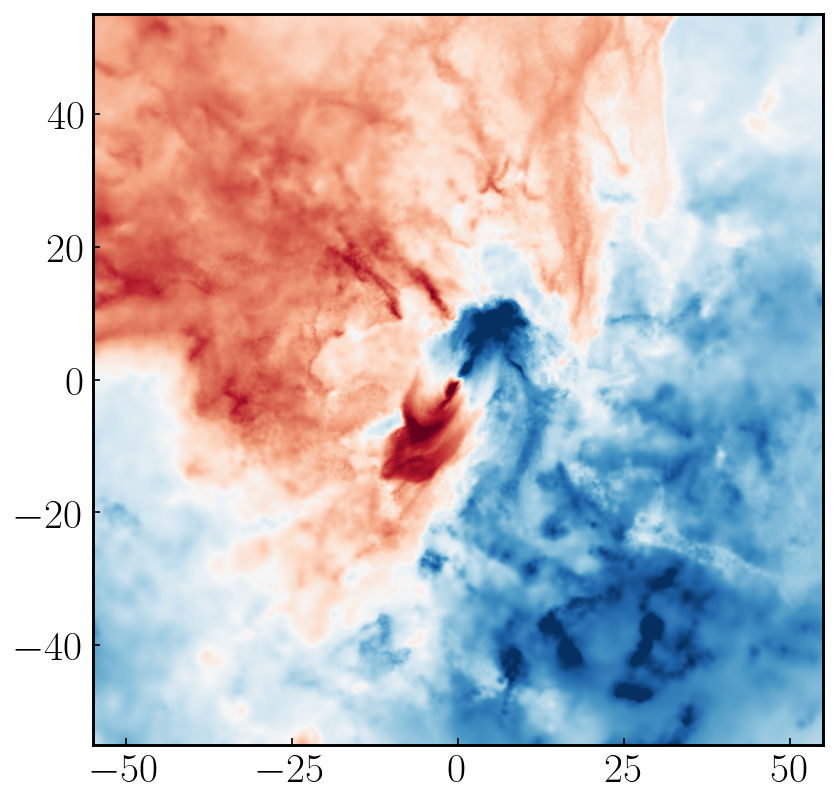

In [139]:
run_batch_100()